## 📚 Exercise 1 - Solutions

In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')


stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')])

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", encoding='utf8') as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

# create the vocabulary
vocabulary = list(set([item for sublist in documents for item in sublist]))
vocabulary.sort()

# compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

# computing the search result
def search_vec(query, topk=10):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    for i in range(topk):
        doc_ids.append(scores[i][1])
    return doc_ids
# HINTS

# natural logarithm function
#     math.log(n,math.e)
# Function to count term frequencies in a document
#     Counter(document)
# most common elements for a list
#     counts.most_common(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vic4ever\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tf_doc_ids = search_vec('computer science')
for i, v in enumerate(tf_doc_ids):
    print(original_documents[v])

Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
Video of Nicola Marzari from @EPFL_en  on Computational Discovery in the 21st Century during #PASC17 now online: https://t.co/tfCkEvYKtq https://t.co/httPdHcK9W
New at @epfl_en Life Sciences @epflSV: "From PhD directly to Independent Group Leader" #ELFIR_EPFL:  Early Independence Research Scholars. See https://t.co/evqyqD7FFl, also for computational biology #compbio https://t.co/e3pDCg6NVb Deadline April 1 2018 at https://t.co/mJqcrfIqkb
@CodeWeekEU is turning 5, yay! We look very much forward to computational thinking unplugged activities during @CodeWeek_CH https://t.co/yDP

In [3]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [4]:
ret_ids = search_vec_sklearn('computer science', features)
print(len(ret_ids))
for i, v in enumerate(ret_ids):
    print(original_documents[v])

26
Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
Exposure Science Film Hackathon 2017 applications open! Come join our Scicomm-film-hacking event! #Science #scicomm https://t.co/zwtKPlh6HT
Le mystère Soulages éblouit la science @EPFL  https://t.co/u3uNICyAdi
@cwarwarrior @EPFL_en @EPFL Doing science at @EPFL_en is indeed pretty cool!!! Thank you for visiting!!!
Blue Brain Nexus: an open-source tool for data-driven science https://t.co/m5yTgXf7ym #epfl
Swiss Data Science on Twitter: "Sign up for @EPFL_en #DataJamDays: learn more a… https://t.co/kNVILHWPGb, see more https://t.co/2wg3BbHBNq
The registration for Exposure Sci

In [5]:
ret_ids = search_vec_sklearn('information systems', features)
print(len(ret_ids))

10


In [6]:
queries = ["computer science", "IC School", "information systems"]

In [7]:
def compute_recall_at_k(predict, gt, k):
    correct_recall = set(predict[:k]).intersection(set(gt))
    return len(correct_recall)/len(gt)

In [8]:
def compute_precision_at_k(predict, gt, k):
    correct_predict = set(predict[:k]).intersection(set(gt))
    return len(correct_predict)/k

In [9]:
def compute_interpolated_precisions(prec_rec):
    max_prec = []
    current_rec = prec_rec[-1][1]
    for k, (prec, rec) in enumerate(prec_rec):
        max_p = prec
        for j, (p, r) in enumerate(prec_rec[k+1:]):
            if p > max_p and r >= rec:
                max_p = p
        max_prec.append(max_p)
    return max_prec

In [10]:
def compute_map(queries, K=10):
    map_score = 0
    prec_rec_dict = []
    for i, query in enumerate(queries):
        ap = 0
        predict = search_vec(query, K)
        gt = search_vec_sklearn(query, features)
        prec_rec = []
        for k in range(1, K+1):
            precision_at_k = compute_precision_at_k(predict, gt, k)
            recall_at_k = compute_recall_at_k(predict, gt, k)
            prec_rec.append((precision_at_k, recall_at_k))
        precs_int = compute_interpolated_precisions(prec_rec)
        
        # Sum interpolated precision only when recall increases
        prev_r = 0
        for j, p_r in enumerate(prec_rec):
            rec = p_r[1]
            if rec > prev_r:
                ap += precs_int[j]
            prev_r = rec
        map_score += ap/len(gt)
        prec_rec_dict.append(prec_rec)
    map_score = map_score/len(queries)
    return map_score, prec_rec_dict

In [19]:
# Alternative solution
def compute_map2(queries, K=10):
    map_score = 0
    for i, query in enumerate(queries):
        predict = search_vec(query, K)
        gt = search_vec_sklearn(query, features)
        p_int = []
        for k in range(K, 0, -1):
            pk = compute_precision_at_k(predict, gt, k)
            
            # Compute interpolated precision
            pint_k = max([pk] + p_int)
            
            # Prepend pint_k to p_int
            p_int.insert(0, pint_k)
        # Only consider precision values when retrieving a relevant document
        p_int_relevant = sum(p_int[i] for i, retrieved in enumerate(predict) if retrieved in gt)
        
        # Divide by number of relevant documents
        map_score += p_int_relevant / len(gt)
    map_score = map_score / len(queries)
    return map_score

In [11]:
map_score, _ = compute_map(queries, K=10)

In [12]:
map_score

0.3437707390648568

In [21]:
compute_map2(queries, K=10)

0.3437707390648568

In [13]:
import matplotlib
import matplotlib.pyplot as plt

prec = [1.0, 0.5, 2/3, 2/4, 3/5, 4/6, 4/7, 4/8, 5/9, 6/10, 7/11 , 7/12, 8/13, 8/14  ]
rec = [1/100, 1/100, 2/100, 2/100, 3/100, 4/100, 4/100, 4/100, 5/100, 6/100, 7/100, 7/100, 8/100, 8/100]
def draw_scatter(prec, rec, prec_int=None):
    fig, ax = plt.subplots()
    ax.xaxis.grid(True)    
    ax.plot(rec,prec,zorder=2) 
#     ax.scatter(rec,prec,zorder=1,c=relevant,cmap=plt.cm.RdYlGn,s=100)
    ax.scatter(rec,prec,zorder=1,s=100)
    if prec_int==None:
        prec_int = compute_interpolated_precisions(list(zip(prec, rec)))
    ax.plot(rec, prec_int, zorder=2)
    ax.scatter(rec,prec_int,zorder=1,s=100)
    ax.set(xlabel='Recall', ylabel='Precision',
           title='Prec-Recall')
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim([0.1,1.1])
    fig.savefig("prec_rec.png")

    plt.show()

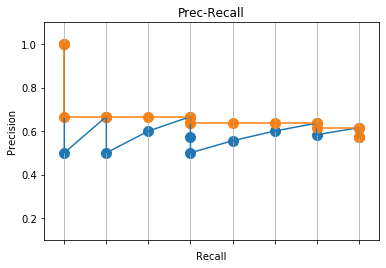

In [14]:
draw_scatter(prec, rec)

## 📚 Exercise 1: Probabilistic Retrieval - SOLUTIONS

### Question a
\begin{align}
P(q|d_j) & = \frac{P(q \cap d_j)}{P(d_j)} \\
& = \sum_{i=1}^m \frac{P(q \cap d_j | k_i) P(k_i)}{P(d_j)} & \text{using $P(A) = \sum_B P(A|B) P(B)$} \\
& = \sum_{i=1}^m \frac{P(q|k_i) P(d_j | k_i) P(k_i)}{P(d_j)} & \text{using conditional independence} \\
& = \sum_{i=1}^m P(k_i |d_j) P(q|k_i) & \text{using Bayes theorem, $P(A|B) = \frac{P(B|A) P(A)}{P(B)}$}
\end{align}

### Question b
$P(q|d_1) = \sum_{i=1}^m P(k_i|d_1) P(q|k_i) = 0 \times \frac{1}{5} + \frac{1}{3} \times 0 + \frac{2}{3} \frac{2}{3} = \frac{4}{9} = 0.4444$

Similarly, for the remaining documents:
+ $P(q|d_2) = 1/15 = 0.0666$
+ $P(q|d_3) = 11/30 = 0.3666$
+ $P(q|d_4) = 3/20 = 0.15$. 
Thus the final ranking is $d_1, d_3, d_4, d_2$.

### Question c
* Similarity
 - For retrieval, both approaches aim to measure the relevance between the query q and document $d_i$ by computing $P(q|d_i)$
* Diference
 - They are different in how $P(q|d)$ is computed. In the above, $P(q|d) = \sum_{i=1}^m P(k_i|d) P(q|k_i)$ while in the lecture $P(q|d) = \prod_{i=1}^m P(k_i|M_{d}) = \prod_{i=1}^m \frac{tf(k_i,d)}{L_d}$

## 📚 Exercise 2: Relevance Feedback - SOLUTIONS


In [11]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
import numpy as np

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
#with open("bread.txt") as f:
with open("epfldocs.txt") as f:
    content = f.readlines()
#original_documents = [x.decode('utf-8').strip() for x in content] # for python2
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]

# create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()

# compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def vectorize_query(query, vocabulary, idf):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    return query_vector
    
def search_vec(query, k):
    query_vector = vectorize_query(query, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    ans = []
    indices = []
    for i in range(min(k,len(original_documents))):
        ans.append(original_documents[scores[i][1]])
        indices.append(scores[i][1])
    return ans, indices, query_vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

[nltk_data] Downloading package stopwords to /Users/elmas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 1. Implement Rocchio's method

In [12]:
def expand_query(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, alpha, beta, gamma):
    # Note: relevant_doc_vecs and non_relevant_doc_vecs are list of vectors, vectors are also lists in this case. 
    # We are using (zip(*list)) to columnwise addition. i.e. [[1,2,3], [4,5,6]] iterate over tuples (1,4),(2,5),(3,6)
    # Check here: https://stackoverflow.com/questions/29139350/difference-between-ziplist-and-ziplist
    # You can use numpy if you want to go fancier
    
    num_rel = len(relevant_doc_vecs)
    num_non_rel = len(non_relevant_doc_vecs)
    
    # Compute the first term in the Rocchio equation
    norm_query_vector = [alpha * weight for weight in query_vector]
    
    # Compute the second term in the Rocchio equation
    norm_sum_relevant = [beta*sum(x)/num_rel for x in zip(*relevant_doc_vecs)]
    
    # Compute the last term in the Rocchio equation
    norm_sum_non_relevant = [-gamma*sum(x)/num_non_rel for x in zip(*non_relevant_doc_vecs)]
    
    # Sum all the terms
    modified_query_vector = [sum(x) for x in zip(norm_sum_relevant, norm_sum_non_relevant, norm_query_vector)]
    
    # Ignore negative elements
    modified_query_vector = [x if x>0 else 0 for x in modified_query_vector]
    return modified_query_vector

#### 2. Test Rocchio's method on the `computer science` query.

In [13]:
ans, result_doc_ids, query_vector = search_vec("computer science", 5)
for i in range(len(ans)):
    print(i,ans[i])

0 Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
1 New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
2 An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
3 New at @epfl_en Life Sciences @epflSV: "From PhD directly to Independent Group Leader" #ELFIR_EPFL:  Early Independence Research Scholars. See https://t.co/evqyqD7FFl, also for computational biology #compbio https://t.co/e3pDCg6NVb Deadline April 1 2018 at https://t.co/mJqcrfIqkb
4 Video of Nicola Marzari from @EPFL_en  on Computational Discovery in the 21st Century during #PASC17 now online: https://t.co/tfCkEvYKtq https://t.co/httPdHcK9W


#### 3. Evaluate the method of variation of the query.

In [14]:
# list of indices marked as relevant
# suppose first three documents were relevant and the rest were irrelevant.
relevant_indices = [0,1,2]
non_relevant_indices = [i for i in range(3, len(ans))]

relevant_doc_ids = [result_doc_ids[i] for i in relevant_indices]
non_relevant_doc_ids = [result_doc_ids[i] for i in non_relevant_indices]

relevant_doc_vecs = [document_vectors[i] for i in relevant_doc_ids]
non_relevant_doc_vecs = [document_vectors[i] for i in non_relevant_doc_ids]

expanded_query = expand_query(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, 1, 1, 1)

new_query = ' '.join([vocabulary[i] for i, val in enumerate(expanded_query) if val>0])

new_ans , not_important_now, idontcare_anymore = search_vec(new_query, 10)

print('Modified query: ', new_query)
new_ans

Modified query:  20162017 amp barth biophys combin comput congrat control distanc epfl eth excit httpstcoarslxzoshq httpstcob9tglxo4kd httpstcoijwbaebocj httpstcoznjk3bz6mo interview model new news no1 no8 patrick professor protein rank scienc show subject univers vdtech via world


['Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ',
 'New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD',
 'An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj',
 'International ranking: #ETH and #EPFL are top institutes',
 'Interview (in French) de Patrick Aebischer, un "innovation slasher" @EPFL_en https://t.co/BtzhxEAEmN',
 'The proteins that domesticated our genomes https://t.co/npGbUKJhBl  via @EPFL_en #VDtech https://t.co/It0SBqlKQc',
 "New software can model natural light from the occupants' perspective https://t.co/RbMmN3Po5v via @EPFL_en #VDtech https://t.co/50enZtwUHi",
 "New software can model natural light from the occupants' perspective https://t.co/RbMmN3Po5v via @EPFL_en #VDtech https://t.co/lLIAvntc9R",
 'L

## 📚 Exercise: Latent Semantic Indexing
In this exercise we would learn about Latent Semantic Indexing (LSI) based retrieval models.

### Goal:
- Implement a search engine using LSI
- Visualize the LSI concepts
- Compare the retrieval results with scikit vector space retrieval method (as an oracle)

### What you are learning in this exercise:
1. Learn more about LSI approach
2. How retrieval results can be different in LSI and vector space retrieval models


## Part1: Implement Latent Semantic Indexing (LSI)
### 1.1 Read the corpus data

In [1]:
#Required libraries.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import math
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
import string
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter
from operator import itemgetter
from pprint import pprint
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

[nltk_data] Downloading package punkt to /Users/romanou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romanou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def read_corpus():
    '''Reads corpus from files.'''
    
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

In [3]:
documents, orig_docs = read_corpus()

In [4]:
len(documents)

1075

### 1.2. Build the vocabulary by selecting top-k frequent words

In [5]:
def create_vocabulary_frequency(corpus, vocab_len):
    '''Select top-k (k = vocab_len) words in term of frequencies as vocabulary'''
    
    count = {}
    for document in corpus:
        for word in document.split():
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
    
    sorted_count_by_freq = sorted(count.items(), key=lambda kv: kv[1], reverse=True)

    vocabulary = [x[0] for x in sorted_count_by_freq[:vocab_len]]
    return vocabulary


In [6]:
vocab_freq = create_vocabulary_frequency(documents, 1000)

In [7]:
vocab_freq

['epfl',
 'epflen',
 'via',
 'new',
 'lausanne',
 'switzerland',
 'vdtech',
 'research',
 'swiss',
 'science',
 'students',
 'innovation',
 'first',
 'martinvetterli',
 'day',
 'solar',
 'great',
 'open',
 'unil',
 'data',
 'technology',
 'learning',
 'thanks',
 'ethen',
 'work',
 'prof',
 'today',
 'startup',
 'talk',
 'see',
 'days',
 'next',
 'congrats',
 'one',
 'good',
 'suisse',
 'researchers',
 'campus',
 'center',
 'time',
 'eth',
 'energy',
 'robots',
 'join',
 'us',
 'epflcampus',
 'cc',
 'made',
 'lab',
 'dgtswitzerland',
 'world',
 'brain',
 'robot',
 'looking',
 'meeting',
 'people',
 'drone',
 'get',
 'future',
 'human',
 'mooc',
 'perovskite',
 'could',
 'epflenac',
 'free',
 'robotics',
 'event',
 'marcelsalathe',
 'conference',
 'proud',
 'light',
 'workshop',
 'forward',
 'week',
 'school',
 'der',
 'president',
 'universities',
 'design',
 'read',
 'im',
 'university',
 'scientists',
 'watch',
 'cours',
 'team',
 'article',
 'last',
 'top',
 'take',
 'exciting',
 'ma

### 1.3. Construct the term document matrix
In this question, you need to construct the term document matrix given the vocabulary and the set of documents.
The value of a cell (i, j) is the term frequency of the term i in document j.

In [8]:
def construct_term_document_matrix(vocabulary, documents):
    # Construct term-doc matrix
    matrix = np.zeros((len(vocabulary), len(documents)))
    for j, document in enumerate(documents):
        counter = Counter(document.split())
        for i, word in enumerate(vocabulary):
            if word in counter:
                matrix[i,j] = counter[word]
    return matrix

In [9]:
term_doc_matrix_freq = construct_term_document_matrix(vocab_freq, documents)

### 1.4. Perform LSI by selecting the first 100 largest singular values of the term document matrix  
Hint 1: np.linalg.svd(M, full_matrices=False) performs SVD on the matrix $\mathbf{M}$ and returns $\mathbf{K}, \mathbf{S}, \mathbf{D}^T$

 -  $\mathbf{K}, \mathbf{D}^T$ are matrices with orthonormal columns
 -  $\mathbf{S}$ is a **vector** of singular values in a **descending** order
 
Hint 2: np.diag(V) converts a vector to a diagonal matrix

Hint 3: To select 
 - The first k rows of a matrix A, use A[0:k, :]
 - The first k columns of a matrix A, use A[:, 0:k]
 - The submatrix from first k rows and k columns of a matrix A, use A[0:k, 0:k]

In [10]:
def truncated_svd(term_doc_matrix, num_val):
    K, S, Dt = np.linalg.svd(term_doc_matrix, full_matrices=False)
    K_sel = K[:,0:num_val]
    S_sel = np.diag(S)[0:num_val,0:num_val]
    Dt_sel = Dt[0:num_val,:]
    return K_sel, S_sel, Dt_sel

In [11]:
K_freq, S_freq, Dt_freq = truncated_svd(term_doc_matrix_freq,100)

### 1.5. Transform the given query
In this question, you need to construct a vector representation for the following query:

In [12]:
query = ['epfl']

In [13]:
def query_to_document_vector(query, vocabulary):
    vector = np.zeros(len(vocabulary))
    for word in query:
        try:
            vector[vocabulary.index(word)] += 1
        except: # if query word is not in vocabulary
            # ignore it
            pass
    return vector

Hint: 
 -  To compute inverse of a matrix M, use np.linalg.inv(M)
 -  To compute the dot product of A, B, use np.dot(A,B)

In [14]:
def construct_query_vector(query, vocabulary, K_sel, S_sel):
    q = query_to_document_vector(query, vocabulary)
    mapper = np.dot(K_sel, np.linalg.inv(S_sel))
    q_trans =  np.dot( q, mapper)
    return q_trans

In [15]:
query_vector_freq = construct_query_vector(query, vocab_freq, K_freq, S_freq)

### 1.6. Retrieve top-10 relevant documents
In this question, you need to retrieve the top-10 documents that are relevant to the query using cosine similarity. You are given a function to compute the cosine simimlarity and a function that return the top-k documents given the query and document vectors.

In [16]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy*1.0/math.sqrt(sumxx*sumyy)

In [17]:
def retrieve_documents(query_vector, top_k, Dt_sel):
    scores = [[cosine_similarity(query_vector, Dt_sel[:,d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved
        

In [18]:
retrieved_ids_freq, retrieved_docs_freq = retrieve_documents(query_vector_freq, 10, Dt_freq)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [19]:
pprint(retrieved_docs_freq)

['Environnement, un marché en pleine croissance https://t.co/ThTcYLrMtn Avec '
 'Philippe Thalmann @EPFL\n',
 'signé @EPFL https://t.co/sRldB2O7PM\n',
 'Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 '
 '#veganfood #EPFLfood https://t.co/wPlLsIt0KD\n',
 "L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q "
 '#epfl\n',
 "L'électrochimie débusque les protéines résistantes aux antibiotiques "
 'https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL\n',
 '#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL '
 'and featured on ZettaBytes! https://t.co/8F4BNL7aAs\n',
 'Ca court, ca court à #carandache #epfl #wwim15 #wwim15_igerslausanne '
 'https://t.co/0bNMBPx50k\n',
 'Femmes en politique, pour en finir avec les seconds rôles '
 'https://t.co/IgIkg8yrxy #epfl\n',
 'Le camion Cargo Congo du @theatredevidy est sur la #PlaceCosandey- ne '
 'manquez pas de venir découvrir ce spectacle de 10 mins jusqu’à 14h puis à '
 '16h @EPFL 

## Part2: Evaluation
In this question, we consider the scikit reference code as an “oracle” that supposedly gives the correct result. You need to compare your retrieval results with this oracle using the F1-score.

In [20]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), vocabulary=vocab_freq, min_df = 1, stop_words = 'english')
features = tf.fit_transform(documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.3):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [21]:
gt_ids = search_vec_sklearn(" ".join(query), features)

In [22]:
for i in gt_ids:
    print(orig_docs[i].strip())

@EPFL Retrouvez votre 1er tweet sélectionné par L'important https://t.co/B2tCt924Cp
Environnement, un marché en pleine croissance https://t.co/ThTcYLrMtn Avec Philippe Thalmann @EPFL
Belle leçon de technologie dans @RTScqfd avec l'exosquelette @twiice_official testé par Silke Pan. https://t.co/4uIdXckvaq #RTScqfd #EPFL
Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 #veganfood #EPFLfood https://t.co/wPlLsIt0KD
L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q #epfl
I see you @EPFL ! https://t.co/BxrHPaMqlX
#Walking on two #legs isn’t as easy as it seems... @EPFL  https://t.co/Af6Shy2CvV https://t.co/ecz2M8Znl4
signé @EPFL https://t.co/sRldB2O7PM
L'électrochimie débusque les protéines résistantes aux antibiotiques https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL
#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL and featured on ZettaBytes! https://t.co/8F4BNL7aAs
Ca court, ca court à #carandache #epfl #wwim15 #wwi

### 2.1. Compute F1-score at 10 between the oracle and your result

In [23]:
def compute_recall_at_k(predict, gt, k):
    correct_recall = set(predict[:k]).intersection(set(gt))
    return len(correct_recall)/len(gt)

In [24]:
def compute_precision_at_k(predict, gt, k):
    correct_predict = set(predict[:k]).intersection(set(gt))
    return len(correct_predict)/k

In [25]:
def f1score(predict, gt, k):
    prec = compute_precision_at_k(predict, gt, k)
    rec = compute_recall_at_k(predict, gt, k)
    print(prec, rec)
    return 2*prec*rec/(prec+rec)

In [26]:
f1score(retrieved_ids_freq, gt_ids, 10)

0.9 0.2571428571428571


0.39999999999999997

## Part3. Visualization
Plot the terms using two principal concepts

### 3.1. Compute the term vectors using two principal concepts
Hint: you can reuse a method from the above

In [27]:
term_vecs_freq, _, _ = truncated_svd(term_doc_matrix_freq,2)

In [28]:
term_vecs_freq.shape

(1000, 2)

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

Hint: You can use plt.scatter(x, y) for a scatter plot. x is a vector of x-axis value and y is a vector of y-axis value

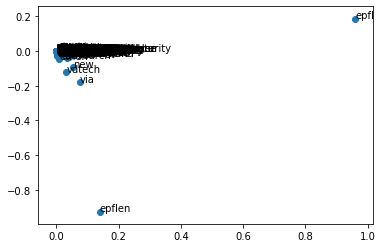

In [30]:
plt.scatter(term_vecs_freq[:, 0], term_vecs_freq[:, 1])
for i, t in enumerate(vocab_freq):
    plt.annotate(t, (term_vecs_freq[i, 0], term_vecs_freq[i, 1]))
plt.show()

### 3.2. Explain the scatter plot of the term vectors

epfl and epflen are two Twitter handles of EPFL which explains why the two principal concepts are mainly made up of these terms.

## 📚 Exercise 1: Introducing Word Embeddings

In this exercise, we would train word embeddings from a state-of-the-art embeddings library (fastText). 

### Goal:
1. Load pretrained word embeddings using fastText library for `epfldocs.txt` data file
2. Visualize the embeddings using t-SNE algorithm
2. Find similar words by compuning the cosine similarity of their embedding vectors


### What you are learning in this exercise:
- Train word embeddings using fastText library
- Learn one way to visualize word embeddings
- How to use word embeddings to find similar words

### 1. FastText installation
The first step of the exercise is to install the fasttext library. Proceed with the following steps:

> pip install fasttext

If you are having problems, try this command:
> sudo apt-get install g++

### 2.1. Generate Embeddings

In [ ]:
import fasttext
import numpy as np

model = fasttext.train_unsupervised('epfldocs.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

### 2.2. Use Pretrained Embeddings
If you are unable to install fasttext, you can use the preembeddings we provide (`model_epfldocs.vec`).

In [ ]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')




### 3. Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities).

t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') # Changed the parameters for provided in the exercise for less KL divergence and better readibility
vis_data = tsne.fit_transform(word_embeddings)

In [ ]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Questions:

1. Observe the plot of word embeddings. Do you observe any patterns?

- <b>You will not encounter a very obvious pattern (because the data is small and too much EPFL oriented) but some small patterns. </b>

    - Words are close to their context words i.e. Professor and MartinVetterli, President and MartinVetterli, Register and conference.

    - Similar words are clustered together: conference, workshop, discussion.

    - Stop words are not clustered together with other words because they cooccur with many words.

    - Artikels are close to each other (Une, du, des)

2. Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings. Find the top 5 terms that are most similar to 'la', 'EPFL', '#robot', 'this'


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=3):
    term_embeddings_dict = {}
    for i,term in enumerate(vocabulary):
        term_embeddings_dict[term] = word_embeddings[i]
        
    if input_term not in term_embeddings_dict:
        return "Term not in the vocabulary"
    
    input_term_embedding = term_embeddings_dict[input_term]
    term_similarities = []
    for term, embedding in term_embeddings_dict.items():
        term_similarities.append([term, cosine_similarity(input_term_embedding.reshape((1,-1)), 
                                                          embedding.reshape((1,-1)))])
        
    sorted_terms = sorted(term_similarities, key = lambda x: -1 * x[1])[0:num_terms]
    
    return sorted_terms

# Note:
# cosine_similarity takes a matrix (of all word vectors) as input,
# so it's better not to loop through all terms to computer term_similarities for efficieny reasons
# I avoided doing this in this part for better readability, 
# although you will see matrix based solution in get_most_similar_documents
# in any case, you will never need to compute similarities by yourself, instead you can use:
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('model.vec')
# similar = model.most_similar(positive=['epfl'],topn=10)

find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)

## 📚 Exercise 2: Basic Search Engine Using Word Embeddings

In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.


### Goal:
1. Implement a search engine that uses word embeddings to retrieve relevant documents (Data file: `epfldocs.txt`)
2. Compare the results with vector space retrieval model


### What you are learning in this exercise:
- Learning to use word embeddings for a search engine 



### 1. Load the data

In [ ]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 

### 2. Aggregate words of each document
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [ ]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 

### 3. Aggregate the query
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector.

Are they seem to relevant?

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    tokens = fasttext.tokenize(query)
    if(len(tokens) == 1):
        if(tokens[0] in vocabulary):
            return vector_dict[tokens[0]]
    elif(len(tokens) > 1):
        vlist = []
        for token in tokens:
            if (token in vocabulary):
                vlist.append(vector_dict[token])
        
        return aggregate_vector_list(vlist, aggfunc)
    else:
        print("%s is not in the vocabulary." % (query))
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None) # This is sorted in ascending order
    indexes = indexes[0]
    indexes = indexes[::-1] # Convert to descending
    return indexes

def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

### 4. Compare the results with the vector space retrieval

In [ ]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    print(new_features.shape)
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [ ]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

### Question
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.

1. Use a bigger corpus
2. Try pretrained vectors (check glove)
3. Preprocess (lowercase, stem) (if the former 2 options are not available)
4. Use heuristics to find similar words and aggregate their vectors, i.e. get a word in the query's stem and the words that have the same stem, get the words with close edit distance to catch hashtags and mentions etc.
    Some examples:
    * MAGA -> What it stands for: Make America Great Again (What MAGA stands for)
    * MAGA -> Cooccuring words, i.e. TCOT (Top Conservatives on Twitter, likely precedes the slogan MAGA)
    * MAGA -> words of concept (Republican) = {Tcot, PJNET, Republic etc.} use the concept vector / average of the word vectors' belonging to that concept. Use wordnet (https://wordnet.princeton.edu) but no MAGA unfortunately :(
5. Search the literature for more ideas.

# Recommender Systems

**Libaries needed: scikit-surprise, pandas, sklearn, numpy. 
To install `scikit-surprise`:**
```
conda install -c conda-forge scikit-surprise tqdm
```

### Goal: 
In this exercise, we will be proceeding in two stages. 
1. The first stage is where we get into the details of how to build our own recommender system to recommend movies to users.
2. In the second stage, we will be an existing library, specialized for recommender systems, which provides more powerful options. We will be testing it on the task of recommending jokes to users.

### What you are learning in this exercise:
1. Getting familiar with item-based collaborative filtering and user-based collaborative filtering.
2. Getting familiar with an existing library for recommender systems.

Let's make sure we have all the requirements ready. In this exercise, you should be filling the empty code sections, marked as `TODO:`

**Note**: We added the `tqdm` library for convenience of monitoring the timing in our loops

In [ ]:
import surprise
import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
`.  vimport warnings
warnings.filterwarnings('ignore')

### Task 1: Exploring the MovieLens dataset

In this part, we'll be using the [MovieLens dataset](https://grouplens.org/datasets/movielens/). This dataset is based on [movielens.org](https://movielens.org/), a site where users can get movie recommendations.

Our first step is to load the relevant file of the dataset, which you can find in the file `u.data` (on the path `data/ml-100k/u.data`).


In [ ]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('data/ml-100k/u.data', sep='\t', names=header)

In [ ]:
df[:15]

Let's first check the number of users and movies in the dataset to get an idea of the scale we're dealing with.

In [ ]:
# TODO: get the number of users and itens
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

We can also get an overall view of the dataset as below. Notice how the ratings range from a minimum of 1 to a maximum of 5.

In [ ]:
df.describe()

Now that the data is loaded, we proceed to splitting it into a training set and a testing set.


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.25, random_state= 42)

Next, let's create the user-item matrices, one for training and another for testing. Each matrix should be a 2D numpy array, with each row corresponding to a user and each column to a movie. A non-zero cell in the matrix is the rating given by the user to the movie (zeros are for the case of no corresponding rating).

**Notice that the user ids and item ids start from 1, so the index (0,0) in your matrix should correspond to `user_id` of 1 and `item_id` of 1.**

In [ ]:
# TODO fill the code to produce a data matrix
def create_data_matrix(data,n_users,n_items):
    """
        This function should return a numpy matrix with a shape (n_users, n_items). 
        Each entry is the rating given by the user to the item
    """
    data_matrix = np.zeros((n_users, n_items))


    for line in data.itertuples():
        data_matrix[line[1]-1, line[2]-1] = line[3]
    return data_matrix

train_data_matrix= create_data_matrix(train_data, n_users, n_items)
test_data_matrix= create_data_matrix(test_data, n_users, n_items)


We can check how our matrices look like at this point. 

In [ ]:
print('train_data_matrix')
print(train_data_matrix.shape)
print('test_data_matrix')
print(test_data_matrix.shape)

### Task 2: Item-based Collaborative Filtering

Now that we've prepared our data, the next mission we have is to create a recommender system following the paradigm of Item-based Collaborative Filtering. In this case, this is translated into "Users who liked this item (movie) also liked …". 



In order to make predictions, we will apply following formula, where 
$N_I(a)$ is the set of neighbors of item $a$, and $b$ is an item rated by user $x$.


\begin{equation}
{r}_{x}(a) =  \frac{\sum\limits_{b \in N_{I}(a)} sim(a, b) r_{x}(b)}{\sum\limits_{b \in N_{I}(a)}|sim(a, b)|}
\end{equation}

As a building block, we'll first write the code for the similarity $sim(a,b)$ metric between each two item vectors in our training matrix. In this case, we will use the cosine similarity metric. The output should be an `n_items` by `n_items` symmetric 2D numpy matrix with the similarity between each couple of items.

**Note**: In this exercise, there are always two ways of achieving the same goal: a slow one via `for` loops and another by benefiting from numpy's speed in matrix operations. Feel free to improve your starting solution to a faster one.

In [ ]:
# TODO fill the code to compute the similarity matrix
from sklearn.metrics.pairwise import pairwise_distances
item_similarity = 1-pairwise_distances(train_data_matrix.T, metric='cosine')

# check how the matrix looks like
print(item_similarity)

Next, we'll use the similarity matrix in the above formula to obtain the predicted ranking for each item `a`.

In [ ]:
# TODO: Fill the code for predicting the ratings. 
# The output is a numpy matrix with the dimensions ((n_users,n_items)) and with the corresponding ranking at each cell.

def item_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    # loop over all the users
    for u in range(n_users):
        # get the items rated by this user
        ranked_items_indices = train_data_matrix[u,:].nonzero()[0]
        for i in range(n_items):
            numerator = 0
            denominator = 0
            for j in ranked_items_indices:
                numerator+=item_similarity[i,j]*train_data_matrix[u,j]
                denominator+=np.abs(item_similarity[i,j])
            if denominator>0:
                filled_matrix[u,i]= numerator/denominator
            else:
                # simply take a random rating in that case 
                filled_matrix[u,i]= np.random.randint(1,6)
    return filled_matrix        

item_prediction = item_based_predict(train_data_matrix, item_similarity)
print(item_prediction)


**Note:** The above implementation can be be made much quicker by changing the loop operations into matrix multiplications. Give it a try!

One further optimization that we can make while speeding up the solution is by focusing on getting a good ranking of the items for a specific user rather than getting the predicted rating value. If we are only interested in the ranking, we do not have to account for the previously ranked items only. The formula can be across all items. This makes the optimizations easier to perform. Check out this [blog post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) for an example.

### Task 3: User-based Collaborative Filtering

The next mission we have is to create a recommender system following the paradigm of User-based Collaborative Filtering. In this case, this is translated into "Users who are similar to you also liked…". 

In order to make predictions, we will apply following formula, where $N_U(x)$ is the set of neighbors of user x and $a$ is an item not rated by x.


\begin{equation}
{r}_{x}(a) = \bar{r}_{x} + \frac{\sum\limits_{y \in N_{U}(x)} sim(x, y) (r_{y}(a) - \bar{r}_{y})}{\sum\limits_{y \in N_{U}(x)}|sim(x, y)|}
\end{equation}

Similar to above, we will first compute the distances between the users in our training matrix, using cosine similarity. The output should be an `n_users` by `n_users` symmetric 2D numpy matrix with the similarity between each couple of users.

In [ ]:
train_data_matrix.shape

In [ ]:
# TODO fill the code to compute the similarity matrix
user_similarity = 1- pairwise_distances(train_data_matrix, metric='cosine')

# print the shape as a sanity check
print(user_similarity.shape)

# check how the matrix looks like
print(user_similarity)

In [ ]:
# TODO: Fill the code for predicting the ratings. 
def user_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    
    # compute the average ratings for each user
    tmp = train_data_matrix.copy()
    tmp[tmp == 0] = np.nan
    user_average_ratings = np.nanmean(tmp, axis=1)
    
    # loop over all the items
    for i in tqdm(range(n_items)):
        # get the users who rated this item
        ranked_users_indices = train_data_matrix[:,i].nonzero()[0]

        for u in range(n_users):
            numerator = 0
            denominator = 0
            for y in ranked_users_indices:
                numerator+=user_similarity[u,y]*(train_data_matrix[y,i]-user_average_ratings[y])
                denominator+=np.abs(user_similarity[u,y])
            if denominator>0:
                filled_matrix[u,i]= user_average_ratings[u]+ numerator/denominator
            else:
                filled_matrix[u,i]= user_average_ratings[u]

    # we ensure that the ratings are in the expected range
    filled_matrix.clip(0,5)
    return filled_matrix   

    
user_prediction = user_based_predict(train_data_matrix, user_similarity)
print(type(user_prediction))

**Note:** As above, this basic implementation can be be made much quicker by changing the loop operations into matrix multiplications. Give it a try!


### Task 4: Evaluating Our Recommenders

We will be evaluating our recommenders using Root Mean Squared Error (RMSE). In the formula below, $r_i$ is the true rating and $\hat{r_i}$ is the predicted one.

\begin{equation}
\mathit{RMSE} =\sqrt{\frac{1}{N} \sum_i (r_i -\hat{r_i})^2}
\end{equation}

In [ ]:
# TODO: add the code for computing RMSE for user and item based methods
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()

    return sqrt(mean_squared_error(prediction, ground_truth))

print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

### Task 5: Introducing Surprise

In this part, we will move to using [Surprise](http://surpriselib.com/), a full-fledged python library, specialized for recommender systems. The goal is to get exposed to such more powerful libraries that can automate a lot of the manual work we had to do above.

For a change, we will be using the [Jester](http://eigentaste.berkeley.edu/dataset/) dataset, obtained from the [Jester Online Joke Recommender System](http://eigentaste.berkeley.edu/index.html). It has over 1.7 million continuous ratings (-10.00 to +10.00) of 150 jokes from 59,132 users: collected between November 2006 - May 2009. Our first step will be to download this dataset. Fortunately, `Surprise` has a built-in loader for the Jester dataset. Make sure you confirm that you want to download the dataset when prompted to do so.

In [ ]:
from surprise import Dataset


# Load the Jester dataset (download it if needed),
data = Dataset.load_builtin('jester')
# split the data into 2 folds for cross-validation.
data.split(n_folds=2)



Next, we will need to train the k-Nearest Neighbors algorithm within Surprise on the Jester dataset (Check the [documentation](http://surprise.readthedocs.io/en/stable/) for `SVD`). For evaluation, Jester allows multiple metrics. You will need to use the `RMSE` and the `MAE` in this case. The training might take a few minutes.

In [ ]:
from surprise import SVD
from surprise import evaluate, print_perf

# TODO: fill the code for evaluating the model based on SVD
# We'll use the SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

The above code was hopefully short, and it's mainly for showing the power of the library. Now that you have trained and evaluated the recommendation algorithm, let's try to find the predicted rating for a single user and item.

In [ ]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(98)  # raw item id (as in the ratings file). They are **strings**!

# TODO get a prediction for user with uid and item iid
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

If you are interested in knowing what the joke was for item 98, you can check the dataset. By default, the dataset will be downloaded in your home directory, under `$HOME/.surprise_data/jester/`. The file `jester_items.dat` has the text of the jokes. 😉

Finally, feel free to explore the library further. It might come in handy for your future projects!


# Text classification with Transformers

### 📚  In this exercise we will create a deep neural network model for text classification, using the Transformer architecture as presented in today's lecture. 

We will use `PyTorch` python library which is an open-source machine learning framework. `PyTorch` is used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. 

Along with `PyTorch` basic features, we will use `torchtext`, a python package that consists of data processing utilities and popular datasets for natural language.

Since we are using state-of-the-art libraries and already implemented preprocessing pipelines, the main purpose of this exercise is not to implement the low level internals of a neural network, but to get familiar with the PyTorch terminology and ecosystem by utilizing its API. Extended reference to the API can be found here: https://pytorch.org/.

In [ ]:
import torch
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter, OrderedDict
from torchtext.vocab import vocab, GloVe
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

## 📚 Exercise 1: Data proprocessing
In this part, we try to preprocess the text input for our (later defined) neural model.
The dataset that will be used to train the model contains IMDB movie reviews, labeled as positive or negative. Further documentation can be found here: http://ai.stanford.edu/~amaas/data/sentiment/

In order to create the preprocessing pipeline, we will extend the `torch.utils.data.Dataset` class which allows us to use pre-loaded datasets as well as our own data. In this way, we will be able to decouple preprocessing from modeling and transform the dataset into a compatible input for the PyTorch pipeline. 

More details can be found here: 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

### Goal:
1. Creating the training dataset by preprocessing the IMDB movie reviews dataset

### What you are learning in this exercise:
1. Getting familiar with custom-designed Dataset classes by extending `torch.utils.data.Dataset`
2. Getting familiar with available tokenizers in `torchtext` library.

In [ ]:
class TextClassificationDataset(Dataset):

    def __init__(self, tokenizer, text_vocab, label_vocab, split='train'):
        print(f'Numericalising tokens for {split} set...', end="", flush=True)
        data = IMDB(split=split)
        self.dset = []
        self.labels = []
        self.text_vocab = text_vocab
        self.label_vocab = label_vocab
        for label, line in data:
            tokens = tokenizer(line.rstrip())
            self.dset.append([self.text_vocab[w] for w in tokens])
            self.labels.append(self.label_vocab[str(label)])
        print('done')
        print(f'Number of {split} samples: {len(self.dset)}')

    def __len__(self):
        return len(self.dset)

    def __getitem__(self, idx):
        tokens = self.dset[idx]
        label = self.labels[idx]
        return tokens, label

    def tokens(self):
        return self.text_vocab.get_itos()

    def vocab_size(self):
        return len(self.text_vocab)

    def num_classes(self):
        return len(self.label_vocab)

    @classmethod
    def build_vocab(cls, tokenizer, split='train', min_freq=1, pad_token='<pad>', unk_token='<unk>'):
        print(f'Building vocab for IMDB...', end="", flush=True)
        data = IMDB(split=split)
        tokens = []
        labels = []
        for label, line in data:
            tokens += tokenizer(line.rstrip())
            labels.append(str(label))

        def create_vocab(counts, mf=1):
            counter = Counter(counts)
            sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
            ordered_dict = OrderedDict(sorted_by_freq_tuples)
            return vocab(ordered_dict, min_freq=mf)

        text_vocab = create_vocab(tokens, min_freq)
        # set index for padding token
        text_vocab.insert_token(pad_token, 0)
        # set default index for unknown token
        text_vocab.append_token(unk_token)
        text_vocab.set_default_index(text_vocab[unk_token])
        label_vocab =  create_vocab(labels)
        print('Done!')
        print(f'Number of tokens: {len(text_vocab)}')
        print(f'Classes: {label_vocab.get_stoi()}')
        return cls(tokenizer, text_vocab, label_vocab, split)

#### Run preprocessing

In [ ]:
# initialize pipeline
seed = 100
torch.manual_seed(seed)
tokenizer = get_tokenizer("basic_english")

Call the `build_vocab()` static function to get the training set.

In [ ]:
# preprocess input
# ------ YOUR CODE HERE ------
train_set = TextClassificationDataset.build_vocab(tokenizer, split='train', min_freq=2)
# ------ YOUR CODE HERE ------

## 📚 Exercise 2: Attention model

As presented in the lecture, attention models, or attention architecture, are input processing techniques for neural networks that allow the network to focus on specific aspects of a complex input and therefore capture contextual dependencies among words in a text.

Transformers use this attention mechanism as a building block, differentially weighting the significance of each part of the input data.

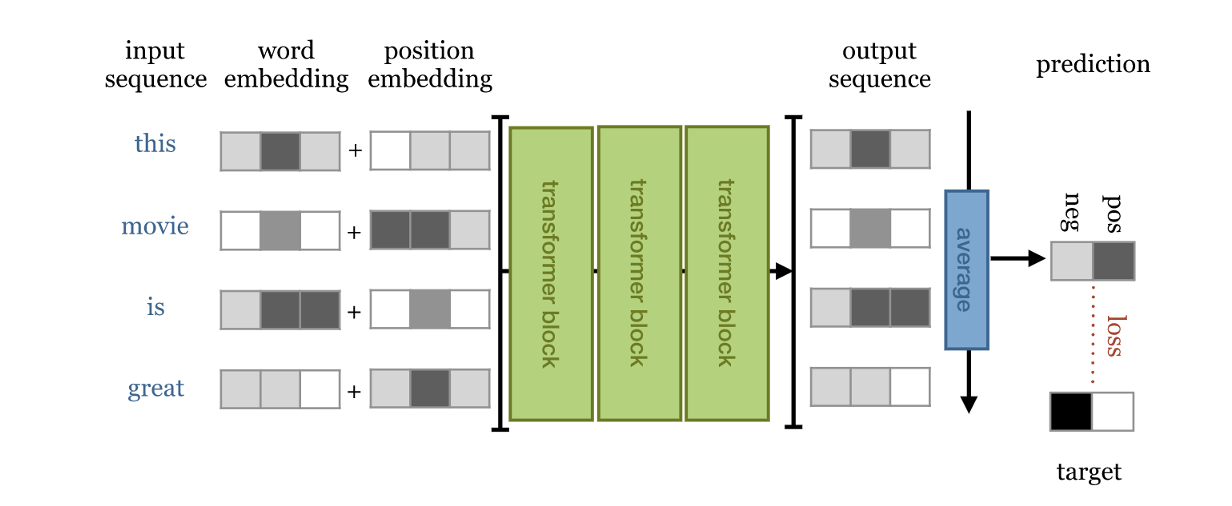

In this exercise, we will build a Transformer based neural network, utilizing the `TransformerEncoderLayer` of `PyTorch`: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

### Goal:
1. Creating the transformer model to be used for text classification
2. Evaluating the nearest neighbors of words before the model is trained

### What you are learning in this exercise:
1. Getting familiar with attention module structure.
2. Using `nn.TransformerEncoderLayer` for creation of transformer blocks.
3. Getting familiar with the padding idea when text inputs are batched (in `collate_batch` function below)


### Embeddings

In this pipeline, we will use as word embeddings the `GloVe` pre-trained representations. This will serve as the input in our model along with the positional embeddings as presented in the diagram above.

In [ ]:
# load pretrained embeddings
vec = GloVe(name='6B', dim=50)
embeddings = vec.get_vecs_by_tokens(train_set.tokens(), lower_case_backup=True)

In [ ]:
class AttentionModel(nn.Module):
    def __init__(
            self,
            vocab_size,
            num_label,
            e_dim=100,
            num_layer=1,
            num_head=2,
            dropout=0.1,
            max_len=512,
            padding_idx=0,
            weights=None,
            freeze=True,
            device=torch.device('cpu')):

        super().__init__()
        self.padding_idx = padding_idx
        self.max_len = max_len
        if weights is None:
            self.word_embeddings = nn.Embedding(vocab_size, e_dim, padding_idx=padding_idx)
            if freeze:
                self.word_embeddings.weight.requires_grad = False
        else:
            self.word_embeddings = nn.Embedding.from_pretrained(weights, freeze=freeze, padding_idx=padding_idx)
        self.position_embeddings = nn.Embedding(max_len, e_dim)
        self.position_ids = torch.arange(max_len).to(device)
        self.LayerNorm = nn.LayerNorm(e_dim, eps=1e-5)
        self.dropout = nn.Dropout(dropout)

        transformer_layer = nn.TransformerEncoderLayer(d_model=e_dim, nhead=num_head, dim_feedforward=e_dim * 4)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layer)
        self.classifier = nn.Linear(e_dim, num_label)
        self.device = device
        self.to(device)

    def forward(self, inputs):
        token_ids, attn_masks = inputs
        batch_size = token_ids.size(0)
        batch_max_length = token_ids.size(1)
        # compute embeddings
        token_embs = self.word_embeddings(token_ids)
        pos_embs = self.position_embeddings(self.position_ids[:batch_max_length])
        embeddings = token_embs + pos_embs
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        # compute contextualised embeddings with transformer
        contextualised_embs = self.transformer(embeddings.permute(1, 0, 2), src_key_padding_mask=attn_masks)
        outputs = contextualised_embs.mean(0)
        logits = self.classifier(outputs)
        return logits

    def knn(self, token_ids, k=10):
        query = self.word_embeddings.weight[token_ids]
        x_src = F.normalize(query)
        x_tgt = F.normalize(self.word_embeddings.weight)
        # compute cosine similarity
        scores = x_src @ x_tgt.t()
        top_values, top_indices = torch.topk(scores, k + 1)
        return top_indices[:, 1:]  # remove top1 since it is the target token

    def collate_batch(self, batch):
        label_list, text_list, lengths = [], [], []
        for (_text, _label) in batch:
            label_list.append(_label)
            text_list.append(_text)
            lengths.append(len(_text))
        max_length = min(max(lengths), self.max_len)
        # truncate or add padding to the right hand side
        for i, _text in enumerate(text_list):
            if len(_text) < max_length:  # pad
                text_list[i] += [self.padding_idx] * (max_length - len(_text))
            else:  # truncate
                text_list[i] = _text[:max_length]
        label_list = torch.tensor(label_list, dtype=torch.long).to(self.device)
        text_list = torch.tensor(text_list, dtype=torch.long).to(self.device)
        attn_mask = text_list == self.padding_idx
        return label_list, (text_list, attn_mask)

In [ ]:
# create model by calling the AttentionModel class
# ------ YOUR CODE HERE ------
model = AttentionModel(
    vocab_size=train_set.vocab_size(), 
    num_label=train_set.num_classes(), 
    e_dim=50,
    max_len=512,
    num_head=2,
    num_layer=1,
    weights=embeddings,
    freeze='store_true',
    padding_idx=train_set.text_vocab['<pad>'],
    device=torch.device('cpu'))
# ------ YOUR CODE HERE ------

#### Evaluate embeddings before training 

We will evaluate how the model performs by finding k-nearest neighbors on a set of words. Since no training has been made yet, note that the knowledge of the model comes only from the pre-trained embeddings.

In [ ]:
@torch.no_grad()
def word_knn(model, valid_set, vocab, top=10):
    print('--------------------------------------------------------------------------------')
    print('Validation - top 10 nearest neighbors ------------------------------------------')
    valid_token_ids = vocab.lookup_indices(valid_set)
    top_indices = model.knn(valid_token_ids, top)

    for i, word in enumerate(valid_set):
        results = ' '.join([vocab.lookup_token(top_indices[i, k].item()) for k in range(top)])
        print(f'{word}: {results}')
    print('--------------------------------------------------------------------------------')

In [ ]:
# print out nearest neighbors before training
words = ['excellent', 'bad', 'terrible', 'awesome']

# ------ YOUR CODE HERE ------
word_knn(model, words, train_set.text_vocab)
# ------ YOUR CODE HERE ------

## 📚 Exercise 3: Training
In this exercise, given preprocessed dataset in Exercise 1 and the model defined in Exercise 2, we try to train the model.
For the training part, we need to define a loss function (using [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) here) and an optimizer (e.g., [Adam](https://pytorch.org/docs/stable/optim.html)).

To efficiently manipulate the data during training, we will use the build-in 
[Data Loader](https://pytorch.org/docs/stable/data.html) class of `PyTorch`.

**Please refer to the documentation of each component in order to call properly the API.**

### Goal:
1. Creating the training loss, optimizer, and train dataloader
2. training the model given below train script.

### What you are learning in this exercise:
1. Getting familiar with usage of `CrossEntropyLoss` for training classification models.
2. Using pytorch optimizers (e.g., `Adam` here) for training a model.
3. Getting familiar with PyTorch dataloader.

In [ ]:
# ------ YOUR CODE HERE ------
# define the loss function
ce_loss = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define training dataloader
train_dataloader = DataLoader(train_set, 
                              batch_size=128, 
                              shuffle=True, 
                              collate_fn=model.collate_batch)
# ------ YOUR CODE HERE ------

In [ ]:
# loop over training epochs
EPOCHS = 1  # change number of epochs and see differences in performance
for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(train_dataloader)
    pbar.set_description("[Epoch {}]".format(epoch))
    for labels, inputs in pbar: 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        # display the loss 
        pbar.set_postfix(loss=loss.item())

## 📚 Exercise 4: Testing

After training, we will use the remaining test set for evaluating our performance in the text classification task on the IMDB dataset. 
### Goal:
1. Creation of test dataloader.
2. Running an evaluation with trained model over test dataset.
3. Computing Precision, Recall and F1 for the trained model.
4. Evaluating the model embeddings using KNN algorithm for finding similar words.


In [ ]:
# ------ YOUR CODE HERE ------
# create test set
test_set = TextClassificationDataset(
    tokenizer, 
    text_vocab=train_set.text_vocab, 
    label_vocab=train_set.label_vocab,
    split='test')

test_dataloader = DataLoader(test_set, 
                             batch_size=128*2, 
                             shuffle=False, 
                             collate_fn=model.collate_batch)
# ------ YOUR CODE HERE ------

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    model.eval()
    for labels, inputs in tqdm(test_dataloader, desc='[Testing]'):
        logits = model(inputs)
        y_pred += logits.argmax(dim=1).tolist()
        y_true += labels.tolist()

In [ ]:
pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print('------- Evaluation metrics --------')
print(f'Precision: {pre*100:.2f}%')
print(f'Recall: {rec*100:.2f}%')
print(f'F1 score: {f1*100:.2f}%')
print('-' * 35)

#### Evaluate embeddings after training

We will evaluate how the model performs by finding k-nearest neighbors on a set of words after training. You will notice that the more epochs the model has run, the more semantically closed the neighbors will be.

In [ ]:
# print out nearest neighbors after training
word_knn(model, ['excellent', 'bad', 'terrible', 'awesome'], train_set.text_vocab)

# Link based ranking



## 📚 Exercise 1: Page rank  (Eigen-vector method)

In the first exercise, we implement the Page Rank algorithm using Eigen vector method.


### Goal:
1. Implementing Page rank with Eigen-vector method.
2. Testing the implemented method on a small Web with three pages (with four different link structures).

### What you are learning in this exercise:
1. Analyzing the output of PageRank for different link structures.

**Preliminaries:** If you want to normalize a vector to L1-norm or L2-norm, you can use `numpy` library as follows:

In [ ]:
from __future__ import print_function, division
import numpy as np

pr = np.array([1,2,3])
print("L1-norm of {0} is {1}".format(pr, pr / np.linalg.norm(pr,1)))
print("L2-norm of {0} is {1}".format(pr, pr / np.linalg.norm(pr,2)))

## Links structure
Consider a tiny Web with three pages A, B and C with no inlinks, and with initial PageRank = 1. Initially, none of the pages link to any other pages and none link to them. 
Run your algorithm for the following cases, and calculate the PageRank for
each case:

1. Link page A to page B.
2. Link all pages to each other.
3. Link page A to both B and C, and link pages B and C to A.
4. Use the previous links and add a link from page C to page B.

**Hints:**
Please note that for this section, we are using the theoretical PageRank computation (without source of rank). See the slide "Transition Matrix for Random Walker" in the lecture notes. Columns of link matrix are from-vertex, rows of link matrix are to-vertex. We take the eigenvector with the largest eigenvalue.
We only care about final ranking of the probability vector. You can choose the normalization (or not) of your choice.

In [ ]:
def create_Rmatrix(L):
#     R = np.multiply(L, 1 / np.sum(L,axis=0)) # Use this matrix multiplication for faster running time if no column is zero
    X = np.sum(L,axis=0)
    n_nodes = L.shape[0]
    R = np.zeros((n_nodes, n_nodes))
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            R[i,j] = L[i,j] / X[0,j] if X[0,j] != 0 else 0
            
#     R = np.multiply(L,R)
    return R

In [ ]:
"""Some time we might want to compute R outside the function to avoid recomputing large matrix"""
def pagerank_eigen(L, R=None):
#   Construct transition probability matrix from L
    if R is None: R = create_Rmatrix(L)
#     Compute eigen-vectors and eigen-values of R
    eigenvalues, eigenvectors = np.linalg.eig(R)
#     Take the eigen-vector with maximum eigven-value
    p = np.absolute(eigenvectors[:,np.argmax(np.absolute(eigenvalues))])
    return (R,p)


In [ ]:
# Test with a sample case, e.g.
L = np.matrix([
    [0,1,1], 
    [1,0,1], 
    [1,1,0]
])
R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

1.Link page A to page B

Result:
$
L =
  \begin{bmatrix}
	0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
  \end{bmatrix}
 ,
R =
  \begin{bmatrix}
	0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
  \end{bmatrix}
  ,
  \vec{p} =
  \begin{bmatrix}
	0 \\
1 \\
0 \\
  \end{bmatrix}
$

In [ ]:
L = np.matrix([
    [0,0,0], 
    [1,0,0], 
    [0,0,0]
])

R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

2.Link all pages to each other

Result:
$
L =
  \begin{bmatrix}
	0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0 \\
  \end{bmatrix}
 ,
R =
  \begin{bmatrix}
	0 & \frac{1}{2} & \frac{1}{2} \\
\frac{1}{2} & 0 & \frac{1}{2} \\
\frac{1}{2} & \frac{1}{2} & 0 \\
  \end{bmatrix}
  ,
  \vec{p} =
  \begin{bmatrix}
	0.577 \\
0.577 \\
0.577 \\
  \end{bmatrix}
$

In [ ]:
L = np.matrix([
    [0,1,1], 
    [1,0,1], 
    [1,1,0]
])

R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

3.Link page A to both B and C, and link pages B and C to A.

Result:
$
L =
  \begin{bmatrix}
	0 & 1 & 1 \\
1 & 0 & 0 \\
1 & 0 & 0 \\
  \end{bmatrix}
 ,
R =
  \begin{bmatrix}
	0 & 1 & 1 \\
\frac{1}{2} & 0 & 0 \\
\frac{1}{2} & 0 & 0 \\
  \end{bmatrix}
  ,
  \vec{p} =
  \begin{bmatrix}
	0.816 \\
0.408 \\
0.408 \\
  \end{bmatrix}
$

In [ ]:
L = np.matrix([
    [0,1,1], 
    [1,0,0], 
    [1,0,0]
])

R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

4.Use the previous links and add a link from page C to page B

Result:
$
L =
  \begin{bmatrix}
	0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 0 & 0 \\
  \end{bmatrix}
 ,
R =
  \begin{bmatrix}
	0 & 1 & \frac{1}{2} \\
\frac{1}{2} & 0 & \frac{1}{2} \\
\frac{1}{2} & 0 & 0 \\
  \end{bmatrix}
  ,
  \vec{p} =
  \begin{bmatrix}
	0.743 \\
0.557 \\
0.371 \\
  \end{bmatrix}
$

In [ ]:
L = np.matrix([
    [0,1,1], 
    [1,0,1], 
    [1,0,0]
])

R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

## 📚 Exercise 2: Page rank  (Iterative method)

In the second exercise, we implement the Page Rank algorithm with an iterative approach.


### Goal:
1. Implementing Page rank with the iterative method.
2. Reading the `ca-GrQc.txt` dataset and constructing its link matrix
3. Testing the implemented algorithm on the constructed link matrix
4. comparing the run-time of iterative method and eigen-vector method.

### What you are learning in this exercise:
1. Benefits of the iterative approach over eigen-vector method.

The eigen-vector method has some numerical issues (when computing eigen-vector) and not scalable with large datasets.

We will apply the iterative method in the slide "Practical Computation of PageRank" of the lecture.

Dataset for practice: https://snap.stanford.edu/data/ca-GrQc.html. It is available within the same paths of this notebook.

In [ ]:
def pagerank_iterative(L, R=None):
    if R is None: #We might want to compute R outside this function to avoid recomputing large matrix
        R = np.multiply(L, 1 / np.sum(L,axis=0))
        
    N = R.shape[0]
    e = np.ones(shape=(N,1))
    q = 0.9

    p = e
    delta = 1
    epsilon = 0.001
    i = 0
    while delta > epsilon:
        p_prev = p
        p = np.matmul(q * R, p_prev)
        p = p + (1-q) / N * e
        delta = np.linalg.norm(p-p_prev,1)
        i += 1

    print("Converged after {0} iterations".format(i))
    return R,p

### Construct link matrix from dataset

In [ ]:
n_nodes = 0
nodes_idx = dict() #Since the nodeIDs are not from 0 to N we need to build an index of nodes
nodes = [] #We also want to store nodeIDs to return the result of ranking vector

# Read the nodes
with open("ca-GrQc.txt") as f:
    for line in f:
        if '#' not in line:
            source = int(line.split()[0])
            target = int(line.split()[1])
            if source not in nodes_idx.keys():
                nodes_idx[source] = n_nodes
                nodes.append(source)
                n_nodes += 1
            if target not in nodes_idx.keys():
                nodes_idx[target] = n_nodes
                nodes.append(target)
                n_nodes += 1
print(n_nodes)
print(nodes[:3])


L = np.zeros((n_nodes, n_nodes))
# Read the edges
with open("ca-GrQc.txt") as f:
    for line in f:
        if "#" not in line:
            source = int(line.split()[0])
            target = int(line.split()[1])
            L[nodes_idx[target], nodes_idx[source]] = 1 #Columns of link matrix are from-vertices
print(L)

## Comparing the run-time of eigen-vector and iterative methods

### You will see that eigen-vector method is slow and has some numerical issues


#### First we pre-compute the R matrix and pass it as argument to Page rank algorithms.

In [ ]:
R = np.multiply(L, 1 / np.sum(L,axis=0))  # note that this doesn't handle zero columns
print(R)

In [ ]:
import time
start_time = time.time()
# Run PageRank
R,p = pagerank_eigen(L, R)
print("--- %s seconds ---" % (time.time() - start_time))
print("Ranking vector: p={0}".format(p))

### Iterative method

In [ ]:
start_time = time.time()
# Run PageRank
R, p = pagerank_iterative(L, R)
print("--- %s seconds ---" % (time.time() - start_time))
print("Ranking vector: p={0}".format(p[:,0]))

## Now let's extract top-k nodes from the ranking vector

In [ ]:
arr = np.array(p[:,0])
k = 3
k_idx = arr.argsort()[-k:][::-1]
print("Top-{0} nodes: {1}".format(k, np.array(nodes)[k_idx]))
print("Their scores: {0}".format(arr[k_idx]))

## 📚 Exercise 3: Ranking Methodology  (Hard)
This exercise is theoretical and you don't need to write code for it:

1. Give a directed graph, as small as possible, satisfying all the properties mentioned below:

    1. There exists a path from node i to node j for all nodes i,j in the directed
graph. Recall, with this property the jump to an arbitrary node in PageRank
is not required, so that you can set q = 1 (refer lecture slides).

    2. HITS authority ranking and PageRank ranking of the graph nodes are different.

2. Give intuition/methodology on how you constructed such a directed graph with
the properties described in (a).

3. Are there specific graph structures with arbitrarily large instances where PageRank
ranking and HITS authority ranking are the same?

#### You can find the solution in `Solution_Ranking_Methodology.pdf`

## 📚 Exercise 4: Hub and Authority

In the last exercise, we implement the (iterative) HITS algorithm to calculate the authority and hub scores for this graph.


### Goal:
1. Implementing HITS algorithm.
2. Identifying the best authority and hub nodes for a small graph (part `a`) as well as the `ca-GrQc.txt` dataset (part `b`)

### a)

Let the adjacency matrix for a graph of four vertices ($n_1$ to $n_4$) be
as follows:

$
A =
  \begin{bmatrix}
	0 & 1 & 1 & 1  \\
	0 & 0 & 1 & 1 \\
	1 & 0 & 0 & 1 \\
	0 & 0 & 0 & 1 \\
  \end{bmatrix}
$

Calculate the authority and hub scores for this graph using the
HITS algorithm with k = 6, and identify the best authority and
hub nodes. (A non-zero element $A_{ij}$ indicates an edge from $i$ to $j$.)

### b)
Apply the HITS algorithm to the `ca-GrQc.txt` dataset (the same dataset as for the `Exercise 2`)

**Hint:** We follow the slide "HITS algorithm" in the lecture. **Denote $x$ as authority vector and $y$ as hub vector**. You can use matrix multiplication for the update steps in the slide "Convergence of HITS". Note that rows of adjacency matrix is from-vertex and columns of adjacency matrix is to-vertex.

In [ ]:
def hits_iterative(A, k = 10):
    N = A.shape[0]
    x0, y0 = 1 / (N**0.5) * np.ones(N), 1 / (N**0.5) * np.ones(N)
    xprev, yprev = x0, y0
    delta1 = delta2 = 1
    epsilon = 0.001 # We can strictly check for convergence rate of HITS algorithm
    l = 0
    while l < k and delta1 > epsilon and delta2 > epsilon:
        y = np.matmul(A, xprev)
        x = np.matmul(np.transpose(A), y) 
        x = x / np.linalg.norm(x,2)
        y = y / np.linalg.norm(y,2)
        delta1 = np.linalg.norm(x-xprev,1)
        delta2 = np.linalg.norm(y-yprev,1)
        xprev = x
        yprev = y
        l += 1
    
    print("Ran a total of {0} iterations with the convergence rate delta1, delta2={1},{2}".format(l, delta1, delta2))
    return xprev, yprev

### Part `a` dataset

In [ ]:
A=np.array([
    [0, 1, 1, 1], 
    [0, 0, 1, 1], 
    [1, 0, 0, 1],
    [0, 0, 0, 1],
])
x, y = hits_iterative(A, k=6)
print("Result using iterative method:\n Authoriy vector x={0}\n Hub vector y={1}".format(x, y))

**Details:**
+ Initialization: 
  
  $x_0 = \frac{1}{4^2}(1,1,1,1) = ( 0.0625,  0.0625,  0.0625,  0.0625)$
  
  $y_0 = \frac{1}{4^2}(1,1,1,1) = ( 0.0625,  0.0625,  0.0625,  0.0625)$
  
+ $k=1$:
  
  $x_1 = \frac{A^t y_0}{||A^t y_0||} = (0.21320072,  0.21320072,  0.42640143,  0.85280287)$
  
  $y_1 = \frac{A x_0}{|| A x_0 ||} = (0.70710678,  0.47140452,  0.47140452,  0.23570226)$
  
+ ...:
  
+ $k=6$:
  
   $x_6 = \frac{A^t y_5}{||A^t y_5||} = (0.16887796,  0.27257494,  0.49774555, 0.80587375)$
  
  $y_6 = \frac{A x_5}{||A x_5||} = (0.65357971,  0.54153747,  0.40815386,  0.33612671)$
  

**Conclusion:**
+ Best authority node: $n_4$. Best hub node: $n_1$.
 
**Check with the theoretical result (convergence condition):**
  
+ $x^*$ is the principal eigenvector (i.e. with largest eigenvalue) of $A^t A$: $(0.16845787,  0.27257056,  0.49801119,  0.80579904)$
  
+ $y^*$ is the principal eigenvector (i.e. with largest eigenvalue) of $A A^t$: $(0.65549599,  0.54215478,  0.4051188,   0.33507008)$

### part `b` dataset
You can reuse the link matrix $L$ (from Exercise 2) to compute the adjacency matrix $A$ of the dataset

In [ ]:
A = np.transpose(L)
print(A)

Run HITS algorithm:

In [ ]:
x, y = hits_iterative(A, 100)
print("Result using iterative method:\n Authoriy vector x={0}\n Hub vector y={1}".format(x, y))

**You can see that the two authority vector and hub vector are the same. So the network must be an undirected graph**

**Interpret the result:**

In [ ]:
k = 3

arr = np.array(x)
k_idx = arr.argsort()[-k:][::-1]
print("Top-{0} authorities: {1}".format(k, np.array(nodes)[k_idx]))
print("Their scores: {0}".format(arr[k_idx]))

arr = np.array(y)
k_idx = arr.argsort()[-k:][::-1]
print("Top-{0} hubs: {1}".format(k, np.array(nodes)[k_idx]))
print("Their scores: {0}".format(arr[k_idx]))

**We can also use linear algebra property of HITS to compute the result (slide "Convergence of HITS"):**.
  
+ $x^*$ is the principal eigenvector (i.e. with largest eigenvalue) of $A^t A$
+ $y^*$ is the principal eigenvector (i.e. with largest eigenvalue) of $A A^t$

However, the computation will be much slower

In [ ]:
xstar_ev, xstar = np.linalg.eig(np.matmul(np.transpose(A),A))
ystar_ev, ystar = np.linalg.eig(np.matmul(A,np.transpose(A)))
xstar, ystar = xstar[:,np.argmax(np.absolute(xstar_ev))], ystar[:,np.argmax(np.absolute(ystar_ev))]
# ystar = -xstar if all(xstar<0) else xstar
# ystar = -ystar if all(ystar<0) else ystar
print("Result using linear algebra:\n Authoriy vector x={0}\n Hub vector y={1}".format(xstar, ystar))

# Graph Mining

## 📚 Exercise 1
Complete the function `compute_modularity` to compute the modularity measure of a given graph.

### Goal:
1. Visualizing two graphs using `networkx` (the Karate Club graph is currently commented out in the code)
2. Completing `compute_modularity` function that aims to measure modularity of a given graph

### What you are learning in this exercise:
1. Getting familiar with `networkx` library.
2. Analyzing modularity measure for different graph inputs

#### Hint: you can install `networkx` package by running the following command in a  notebook cell: `!conda install networkx --yes `

/Users/duong/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


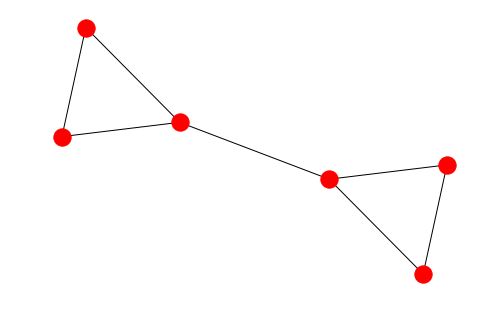

In [1]:
import networkx as nx
import numpy as np

%matplotlib inline

M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw(G)

#G = nx.karate_club_graph()
#nx.draw(G)

In [12]:
for node in [0,1,2]:
    G.nodes[node]['community'] = 0
for node in [3,4,5]:
    G.nodes[node]['community'] = 1
len(G.edges)

7

In [9]:
# The degree of a node: G.degree[node_id]
# The neighbors of a node: G.neighbors(node_id)
# Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
def compute_modularity(G, nodes_community):
    ''' input: G:nx.Graph 
               nodes_community:{node_id:community_id}
       output: Q (modularity metric)
    '''
    Q = 0
    
    m = len(G.edges)
    for node_i in G.nodes:
        for node_j in G.nodes:
            if nodes_community[node_i] == nodes_community[node_j]:
                Q += G.number_of_edges(node_i, node_j) - G.degree[node_i]*G.degree[node_j]/(2*m)
    Q = Q/(2*m)

    return Q 

In [11]:
nodes_community = {}
for node in G.nodes():
    nodes_community[node] = G.nodes[node]['community']
Q = compute_modularity(G, nodes_community)
print(Q)

0.3571428571428571


## 📚 Exercise 2
Suppose that you have an undirected social graph G = (U, V), where U - set of nodes, V - set of edges.

<img src="graph.png" width="400">

Compute betweenness for the graph G and output the communities for the following betweenness threshold : 4, 6.

#### SOLUTION

Following the Girvan- Newman algorithm, first we visit each node X once and compute the number of shortest paths from X to each of the other nodes. To do so, we run BFS starting at node X.

##### Compute Betweenness - Path Counting:

Let’s assume we start from the node E. Label each node by the number of shortest paths that reach it from the root ($N_{shortest}$). So, we label the root with 1. We continue top-down. D and F have one parent so they are labeled by the score of their parent. Similarly for B, A and C. However, G has two parents, thus its label is equal to 2. Finally, we need to calculate for each edge e the fraction of shortest paths from X to Y that go through e, e.g., from E to all other nodes.

![alt text](path.png "Title")

#### Compute Betweenness - Edge Flow:

1. The flow that arrives at every node is 1.
2. In addition each node receives the flow of its children. The flow of its children is distributed over the parents, proportionally to the number of paths that are leading to those parents (previous stage). For example: B: 1 + (1+1) = 3. F = 1 + (½) = 1.5

![alt text](flow.png "Title")

To complete the calculation we need to apply the procedure to every node as the root and sum the contributions. Finally, we need to divide the credit for each edge by 2 since every shortest path is discovered twice, once for each of its endpoints. The final betweenness scores for the edges are the following. 

![alt text](flow2.png "Title")

Thus, we obtain the following clusters for the betweenness of 4 and 6.

![alt text](b4.png "Title")

![alt text](b6.png "Title")


## 📚 Exercise 13: Entity & Relation Extraction

### Task 1: Relation extraction from Wikipedia articles

Use Wikipedia to extract the relation `directedBy(Movie, Person)` by applying pattern based heuristics that utilize: *Part Of Speech Tagging*, *Named Entity Recognition* and *Regular Expressions*.

#### Required Library: SpaCy
- ```conda install -y spacy```
- ```python -m spacy download en```

In [1]:
import urllib.request, json, csv, re
import spacy

if int(spacy.__version__[0]) > 2:
    nlp = spacy.load("en_core_web_sm")
else:
    nlp = spacy.load("en")

In [2]:
# read tsv with input movies
def read_tsv():
    movies = []
    with open("movies.tsv", "r") as file:
        tsv = csv.reader(file, delimiter="\t")
        next(tsv)  # remove header
        movies = [{"movie": line[0], "director": line[1]} for line in tsv]
    return movies


# parse wikipedia page
def parse_wikipedia(movie):
    txt = ""
    try:
        with urllib.request.urlopen(
            "https://en.wikipedia.org/w/api.php?format=json&action=query&prop=extracts&exintro=&explaintext=&titles="
            + movie
        ) as url:
            data = json.loads(url.read().decode())
            txt = next(iter(data["query"]["pages"].values()))["extract"]
    except:
        pass
    return txt

#### 1) Parse the raw text of a Wikipedia movie page and extract named (PER) entities.

In [3]:
def find_PER_entities(txt):
    txt = nlp(txt)

    persons = []
    for e in txt.ents:
        if e.label_ == "PERSON":
            persons.append(e.text)
    return persons

#### 2) Given the raw text of a Wikipedia movie page and the extracted PER entities, find the director.

In [4]:
# simple heuristic: find the next PER entity after the word 'directed'
def find_director(txt, persons):
    txt = re.sub("[!?,.]", "", txt).split()
    for p1 in range(0, len(txt)):
        if txt[p1] == "directed":
            for p2 in range(p1, len(txt)):
                for per in persons:
                    if per.startswith(txt[p2]):
                        return per
    return ""

In [5]:
movies = read_tsv()

fp = 0
statements = []
for m in movies:
    txt = parse_wikipedia(m["movie"])
    persons = find_PER_entities(txt)
    director = find_director(txt, persons)

    if director != "":
        statements.append(m["movie"] + " is directed by " + director + ".")
        if director != m["director"]:
            fp += 1

#### 3) Compute the precision and recall based on the given ground truth (column Director from tsv file) and show examples of statements that are extracted.

In [6]:
# compute precision and recall
fn = len(movies) - len(statements)
tp = len(statements) - fp
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: {:.0%}".format(precision))
print("Recall: {:.0%}".format(recall))

print()
print("***Sample Statements***")
for s in statements[:5]:
    print(s)

Precision: 77%
Recall: 78%

***Sample Statements***
13_Assassins_(2010_film) is directed by Takashi Miike.
14_Blades is directed by Daniel Lee.
22_Bullets is directed by Richard Berry.
Alien_vs_Ninja is directed by Seiji Chiba.
Bad_Blood_(2010_film) is directed by Dennis Law.


## Task 2: Named Entity Recognition using Hidden Markov Model


Define a Hidden Markov Model (HMM) that recognizes Person (*PER*) entities.
Particularly, your model must be able to recognize pairs of the form (*firstname lastname*) as *PER* entities.
Using the given sentences as training and test set:

In [7]:
training_set = [
    "The best blues singer was Bobby Bland while Ray Charles pioneered soul music .",
    "Bobby Bland was just a singer whereas Ray Charles was a pianist , songwriter and singer .",
    "None of them lived in Chicago .",
]

test_set = [
    "Ray Charles was born in 1930 .",
    "Bobby Bland was born the same year as Ray Charles .",
    "Muddy Waters is the father of Chicago Blues .",
]

#### 1) Annotate your training set with the labels I (for PER entities) and O (for non PER entities).
	
    *Hint*: Represent the sentences as sequences of bigrams, and label each bigram.
	Only bigrams that contain pairs of the form (*firstname lastname*) are considered as *PER* entities.

In [8]:
# Bigram Representation
def getBigrams(sents):
    return [
        [b[0] + " " + b[1] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
        for l in sents
    ]


bigrams = getBigrams(training_set)

# Annotation
PER = ["Bobby Bland", "Ray Charles"]
annotations = [
    [[b, "I" if b in PER else "O"] for b in sentence] for sentence in bigrams
]

print("Annotation")
for annotated_sentence in annotations:
    print(annotated_sentence)

Annotation
[['The best', 'O'], ['best blues', 'O'], ['blues singer', 'O'], ['singer was', 'O'], ['was Bobby', 'O'], ['Bobby Bland', 'I'], ['Bland while', 'O'], ['while Ray', 'O'], ['Ray Charles', 'I'], ['Charles pioneered', 'O'], ['pioneered soul', 'O'], ['soul music', 'O'], ['music .', 'O']]
[['Bobby Bland', 'I'], ['Bland was', 'O'], ['was just', 'O'], ['just a', 'O'], ['a singer', 'O'], ['singer whereas', 'O'], ['whereas Ray', 'O'], ['Ray Charles', 'I'], ['Charles was', 'O'], ['was a', 'O'], ['a pianist', 'O'], ['pianist ,', 'O'], [', songwriter', 'O'], ['songwriter and', 'O'], ['and singer', 'O'], ['singer .', 'O']]
[['None of', 'O'], ['of them', 'O'], ['them lived', 'O'], ['lived in', 'O'], ['in Chicago', 'O'], ['Chicago .', 'O']]


#### 2) Compute the transition and emission probabilities for the HMM (use smoothing parameter $\lambda$=0.5).

    *Hint*: For the emission probabilities you can utilize the morphology of the words that constitute a bigram (e.g., you can count their uppercase first characters).

In [9]:
lambda_ = 0.5

# Transition Probabilities
transition_prob = {}

I_count = sum(
    a[1] == "I" for annotated_sentence in annotations for a in annotated_sentence[:-1]
)
O_count = sum(
    a[1] == "O" for annotated_sentence in annotations for a in annotated_sentence[:-1]
)

# Initial probabilities
transition_prob["P(I|start)"] = float(
    sum(annotated_sentence[0][1] == "I" for annotated_sentence in annotations)
) / len(annotations)
transition_prob["P(O|start)"] = 1 - transition_prob["P(I|start)"]


O_after_O_count = 0
O_after_I_count = 0
I_after_O_count = 0
I_after_I_count = 0
for annotated_sentence in annotations:
    for i, (_, token) in enumerate(annotated_sentence[:-1]):
        next_token = annotated_sentence[i + 1][1]
        if token == "O":
            if next_token == "O":
                O_after_O_count += 1
            else:
                I_after_O_count += 1
        else:
            if next_token == "O":
                O_after_I_count += 1
            else:
                I_after_I_count += 1

transition_prob["P(O|O)"] = O_after_O_count / O_count
transition_prob["P(O|I)"] = O_after_I_count / I_count
transition_prob["P(I|O)"] = I_after_O_count / O_count
transition_prob["P(I|I)"] = I_after_I_count / I_count

print("Transition Probabilities", transition_prob, sep="\n")
print()

# Emission Probabilities
emission_prob = {}


def count_upper_first_char(bigram):
    count = 0
    if bigram.split(" ")[0][0].isupper():
        count += 1
    if bigram.split(" ")[1][0].isupper():
        count += 1
    return count


both_upper_count_O = 0
both_upper_count_I = 0
one_upper_count_O = 0
one_upper_count_I = 0
no_upper_count_O = 0
no_upper_count_I = 0
for a in sum(annotations, []):
    if count_upper_first_char(a[0]) == 2 and a[1] == "O":
        both_upper_count_O += 1
    elif count_upper_first_char(a[0]) == 2 and a[1] == "I":
        both_upper_count_I += 1
    elif count_upper_first_char(a[0]) == 1 and a[1] == "O":
        one_upper_count_O += 1
    elif count_upper_first_char(a[0]) == 1 and a[1] == "I":
        one_upper_count_I += 1
    elif count_upper_first_char(a[0]) == 0 and a[1] == "O":
        no_upper_count_O += 1
    elif count_upper_first_char(a[0]) == 0 and a[1] == "I":
        no_upper_count_I += 1


default_emission = 1 / len(sum(bigrams, [])) * (1 - lambda_)

emission_prob["P(2_upper|O)"] = (
    both_upper_count_O / O_count
) * lambda_ + default_emission
emission_prob["P(2_upper|I)"] = (
    both_upper_count_I / I_count
) * lambda_ + default_emission
emission_prob["P(1_upper|O)"] = (
    one_upper_count_O / O_count
) * lambda_ + default_emission
emission_prob["P(1_upper|I)"] = (
    one_upper_count_I / I_count
) * lambda_ + default_emission
emission_prob["P(0_upper|O)"] = (
    no_upper_count_O / O_count
) * lambda_ + default_emission
emission_prob["P(0_upper|I)"] = (
    no_upper_count_I / I_count
) * lambda_ + default_emission

print("Emission Probabilities", emission_prob, sep="\n")

Transition Probabilities
{'P(I|start)': 0.3333333333333333, 'P(O|start)': 0.6666666666666667, 'P(O|O)': 0.8928571428571429, 'P(O|I)': 1.0, 'P(I|O)': 0.10714285714285714, 'P(I|I)': 0.0}

Emission Probabilities
{'P(2_upper|O)': 0.014285714285714285, 'P(2_upper|I)': 0.5142857142857142, 'P(1_upper|O)': 0.21071428571428572, 'P(1_upper|I)': 0.014285714285714285, 'P(0_upper|O)': 0.37142857142857144, 'P(0_upper|I)': 0.014285714285714285}


#### 3) Predict the labels of the test set and compute the precision and the recall of your model.

In [10]:
# Prediction
bigrams = getBigrams(test_set)
entities = []
for sentence in bigrams:
    prev_state = "start"
    for b in sentence:
        I_prob = (
            transition_prob["P(I|" + prev_state + ")"]
            * emission_prob["P(" + str(count_upper_first_char(b)) + "_upper|I)"]
        )
        O_prob = (
            transition_prob["P(O|" + prev_state + ")"]
            * emission_prob["P(" + str(count_upper_first_char(b)) + "_upper|O)"]
        )

        if I_prob > O_prob:
            entities.append(b)
            prev_state = "I"
        else:
            prev_state = "O"

print("Predicted Entities\n", entities, "\n")

Predicted Entities
 ['Ray Charles', 'Bobby Bland', 'Ray Charles', 'Muddy Waters', 'Chicago Blues'] 



Precision is *80%* while recall is *100%*. 

#### 4) Comment on how you can further improve this model.

We could increase precision by computing also the probabilities for unigrams and averaging them in the prediction step.

# 📚 Exercise 12: Semantic Web

In this exercise, we will understand the functioning of RDF statements and their applications.

## Overview:
You are an engineer parsing ancient greek literature. You are overwhelmed by the mythical heroes and their stories, that you decide to put structure on this textual knowledge. You will need to parse the given sentences and create a Knowledge Graph that represents the information of the text to be easily searched.

## Goal:
1. Create a Knowledge Graph from a given text.
2. Perform queries on the KG.
3. Insert new knowledge and re-run queries.

## What are you learning in this exercise:
- Conceptualize and apply the RDF creation derived from the text.
- Run queries on Knowledge Graphs.

### Task 1: Create a Knowledge Graph

Consider the following sentences:

```Aphrodite and Eros are Gods.```

```Aphrodite is a parent of Eros.```

```Aphrodite is beautiful.```

```Aphrodite is happy.```

> #### 1) Formalize these sentences as RDF statements. Use a python dictionary to indicate the *subject*, *predicate* and *object* of a statement.

In [2]:
statements = []
#statement template: {'s':'', 'p':'', 'o':''}
statements.append({'s':'Aphrodite', 'p':'isa', 'o':'God'})
statements.append({'s':'Eros', 'p':'isa', 'o':'God'})
statements.append({'s':'Aphrodite', 'p':'isParentOf', 'o':'Eros'})
statements.append({'s':'Aphrodite', 'p':'isa', 'o':'beautiful'})
statements.append({'s':'Aphrodite', 'p':'isa', 'o':'happy'})

> #### 2) Specify which are the *classes*, the *instances* and the *properties* in the above statements.


- Classes: God, beautiful, happy
- Instances: Aphrodite, Eros
- Properties: isa, isParentOf 

> #### 3) Pose the following query to your Knowledge Graph and show the results.
    Who is happy?

In [3]:
def query():
    results = []
    for s in statements:
        if s['p'] == 'isa' and s['o'] == 'happy':
            results.append(s['s'])
    print(results)

query()

['Aphrodite']


### Task 2: Derive new Knowledge

Now consider the following inference rules:

``` Every person is happy if one of his/her parents is successful. ```

``` All happy persons are successful. ```

> #### 1) Transform and apply them to your Knowledge Graph. Include the new statements that will be derived in the Knowledge Graph.

In [5]:
def inference():
    
    new_statements = True

    while (new_statements):
        new_statements = False

        for s1 in statements:
            if s1['p'] == 'isa' and s1['o'] == 'successful':
                for s2 in statements:
                    if s1['s'] == s2['s'] and s2['p'] == 'isParentOf':
                        statement = {'s':s2['o'], 'p':'isa', 'o':'happy'}
                        if statement not in statements:
                            statements.append(statement)
                            new_statements = True
        for s in statements:
            if s['p'] == 'isa' and s['o'] == 'happy':
                    statement = {'s':s['s'], 'p':'isa', 'o':'successful'}
                    if statement not in statements:
                        statements.append(statement)
                        new_statements = True

> #### 2) Give an example of a rule that would bring incosistency in the Knowledge Graph. 

A person is not successful if one of his/her parents is successful.

> #### 3) Pose again the query from Question 3 of Task 1. Are you getting the same results?

In [6]:
inference()
query()

['Aphrodite', 'Eros']


Credits @ [Knowledge Technologies (PMS509)](http://cgi.di.uoa.gr/~pms509)

# 📚 Exercise: Taxonomy Induction Solutions



## Question 1 - Relations Extraction

  
  
  ###  Question 1.a

  Load the given file <b>wiki_food_en.txt</b> into memory using the following code:
  
  
  

In [1]:
def load_text_file(filename):
    file_text = []
    with open(filename) as fp:
        for line in fp:
            file_text.append(line.strip().lower())
    return " ".join(file_text)

file_text = load_text_file("wiki_food_en.txt")

In [2]:
## Code for finding matches

import re

def find_matches(file_text, regexp_string):
    #Compile a regular expression 
    regexp = re.compile(regexp_string)
    
    #Find all matches with the given regular expression
    # findall function finds all matches of the given regular expression in the file_text.
    matches = re.findall(regexp, file_text)
    
    return matches

isa_matches = find_matches(file_text, "[a-z]+ is a [a-z]+")

 ###  Question 1.b

Run the above code for relations extraction with the following lexico-syntactic patterns:

<ol>
  <li>X such as Y</li>
  <li>such X as Y</li>
<li>X and other Y</li>  
</ol>

In [3]:
matches = find_matches(file_text, "[a-z]+ such as [a-z]+")
for i,m in enumerate(matches[0:20]):
    print (str(i+1) + ") " + m)

1) pig such as the
2) beverages such as cocktails
3) emulsifiers such as egg
4) varieties such as allioli
5) pests such as the
6) ceremonies such as weddings
7) pests such as navel
8) versions such as the
9) pests such as the
10) ceremonies such as weddings
11) pests such as navel
12) versions such as the
13) illnesses such as infections
14) pans such as a
15) manufacturing such as acetic
16) aid such as modified
17) session such as of
18) plants such as pear
19) foods such as apple
20) cheeses such as cheddar


2,3,6,10,13,19,20 are correct.
<br>

In [4]:
matches = find_matches(file_text, "such [a-z]+ as [a-z]+")
for i,m in enumerate(matches[0:20]):
    print (str(i+1) + ") " + m)

1) such serves as an
2) such flavors as chocolate
3) such factors as territorial
4) such countries as germany
5) such foods as pizza
6) such words as the
7) such factors as territorial
8) such companies as arienti
9) such ingredients as water
10) such ingredients as water
11) such places as thailand
12) such places as thailand
13) such parameters as the
14) such species as the
15) such nougat as the
16) such items as sliced
17) such species as the
18) such conditions as abscesses
19) such plants as the
20) such items as dry


2,4,5,9,10,11,12,18 are correct.
<br>

In [5]:
matches = find_matches(file_text,  "[a-z]+ and other [a-z]+")
for i,m in enumerate(matches[0:20]):
    print (str(i+1) + ") " + m)

1) france and other countries
2) figs and other recipes
3) azerbaijan and other central
4) olives and other tree
5) azerbaijan and other central
6) olives and other tree
7) rye and other flours
8) france and other european
9) sauces and other sauces
10) mixes and other gluten
11) petals and other flower
12) petals and other flower
13) tariff and other supports
14) wars and other fairtrade
15) wine and other ingredients
16) date and other agronomic
17) soups and other foods
18) patties and other bulk
19) spices and other substances
20) sugars and other components


1,4,6,7,15,17,19,20 are correct.
<br>
The main difference between patterns 1,2 vs. 3 are that the hypernym appears first in 1,2 whereas it appears later in the pattern 3. For example:

1. hypernym such as hyponym
2. such hypernym as hyponym
3. hyponym and other hypernym

## Question 2 - Graph Construction


###  Question 2.a


Load the IsA relations of the food domain from the given file "food_isa_relations.txt" using the following code:

In [6]:
rels = []
with open("food_isa_relations.txt") as fp:
    for line in fp.readlines():
        toks = line.strip().split('\t')
        rels.append((toks[0],toks[1],float(toks[2])))

###  Question 2.b


In [7]:
from collections import defaultdict

noisy_relations = defaultdict(dict)
for hypo, hyper, freq in rels:
    noisy_relations[hypo][hyper] = freq

In [8]:
noisy_relations['apple']

{'apple': 0.41334243636,
 'brand': 0.0915626602388,
 'company': 0.547120747653,
 'company in the world': 0.0747098410221,
 'crop': 0.0988772876235,
 'flavour': 0.0858994706649,
 'food': 0.147812587177,
 'fruit': 1.0,
 'fruit tree': 0.115782511138,
 'hardware company': 0.0897298351702,
 'ingredient': 0.068957229831,
 'manufacturer': 0.079702775123,
 'orange': 0.155466692675,
 'product': 0.0697003665663,
 'rival': 0.0788062030625,
 'tag': 0.0736281177128,
 'tech company': 0.120745147762,
 'technology company': 0.0755438963724,
 'tree': 0.110838111316,
 'vegetable': 0.132148274312}

In [9]:
for hypo in noisy_relations.keys():
    sorted_hypernyms = sorted(noisy_relations[hypo].items(), key = lambda x: -1 *x[1])
    noisy_relations[hypo] = {k:v for k,v in sorted_hypernyms[0:5]}
    
# Printed filtered noisy relations.
noisy_relations['apple']   

{'apple': 0.41334243636,
 'company': 0.547120747653,
 'food': 0.147812587177,
 'fruit': 1.0,
 'orange': 0.155466692675}

###  Question 2.c

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

for hypo in noisy_relations.keys():
    for hyper in noisy_relations[hypo].keys():
        G.add_edge(hypo, hyper)
  
for p in nx.all_simple_paths(G, source='apple', target='food'):
    print (p)

['apple', 'food']
['apple', 'fruit', 'ingredient', 'food']
['apple', 'fruit', 'food']
['apple', 'orange', 'fruit', 'ingredient', 'food']
['apple', 'orange', 'fruit', 'food']


In [11]:
for p in nx.all_simple_paths(G, source='fusilli', target='food'):
    print (p)

['fusilli', 'pasta', 'dish', 'food']
['fusilli', 'pasta', 'ingredient', 'food']
['fusilli', 'pasta', 'food']


In [12]:
for p in nx.all_simple_paths(G, source='okra', target='food'):
    print (p)

['okra', 'vegetable', 'ingredient', 'food']
['okra', 'vegetable', 'food']


In general, the shorter paths are more likely to be accurate. the longer paths are more likely to contain noisy edges.


###  Question 2.d


In [13]:
%matplotlib inline

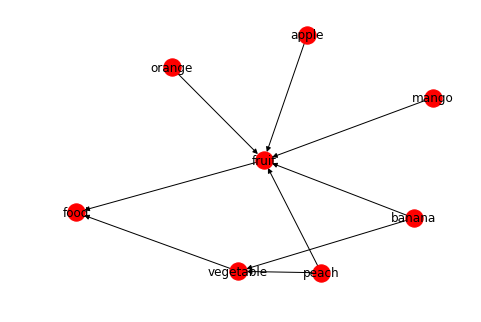

In [14]:

def select_paths(vocab, root, l, nx_graph):
    retained_paths = []
    for term in vocab:
        for path in nx.all_simple_paths(nx_graph, source=term, target=root):
            if len(path) == l:
                retained_paths.append(path)
    return retained_paths


def aggregate_paths(paths):
    agg_graph = defaultdict(dict)
    
    for path in paths:
        for i,term in enumerate(path[0:len(path) -1]):
            agg_graph[term][path[i+1]] = 1
            
    return agg_graph


V = ['apple', 'mango', 'peach', 'orange', 'banana']
root = 'food'

graph = aggregate_paths(select_paths(V, root, 3, G))
 

# Plot the graph
def plot_graph(graph):
    Gt = nx.DiGraph()
    for k in graph.keys():
        for k1 in graph[k].keys():
            Gt.add_edge(k,k1)
    nx.draw(Gt, with_labels=True)
    plt.show()
    
plot_graph(graph)

###  Question 2.e

Plot the aggregated graph using the previous steps but with different path lengths (For example, 2 or 4). What do you notice?



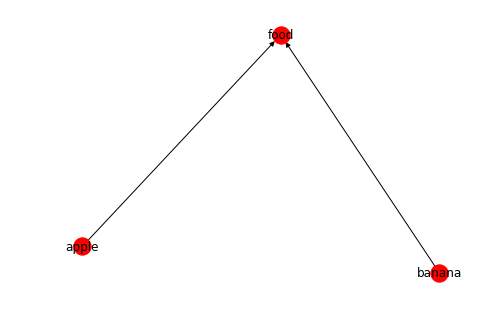

In [15]:
graph = aggregate_paths(select_paths(V, root, 2, G))
plot_graph(graph)

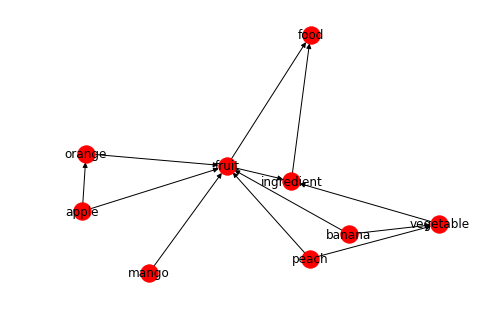

In [16]:
graph = aggregate_paths(select_paths(V, root, 4, G))
plot_graph(graph)

As we can observe, when the path lengths increase, the noise in the resulting graph increases.

###  Question 2.f


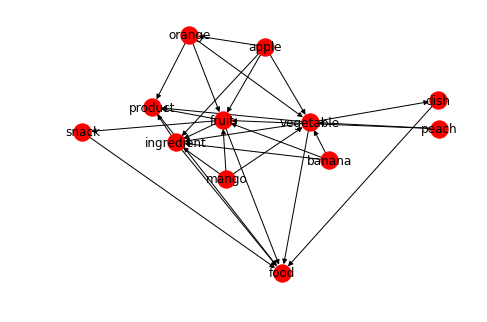

In [17]:
rels = []
with open("food_isa_relations.txt") as fp:
    for line in fp.readlines():
        toks = line.strip().split('\t')
        rels.append((toks[0],toks[1],float(toks[2])))
        
noisy_relations = defaultdict(dict)
for hypo, hyper, freq in rels:
    noisy_relations[hypo][hyper] = freq
    
G=nx.DiGraph()

for hypo in noisy_relations.keys():
    for hyper in noisy_relations[hypo].keys():
        G.add_edge(hypo, hyper)
    
graph = aggregate_paths(select_paths(V, root, 4, G))
plot_graph(graph)

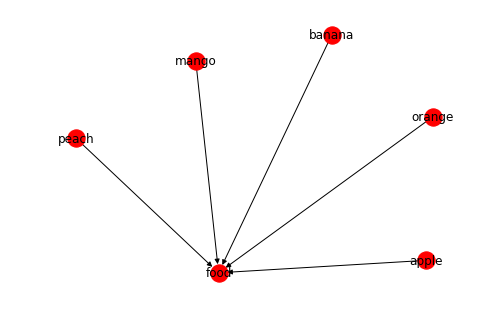

In [18]:
graph = aggregate_paths(select_paths(V, root, 2, G))
plot_graph(graph)

## This graph has higher recall.

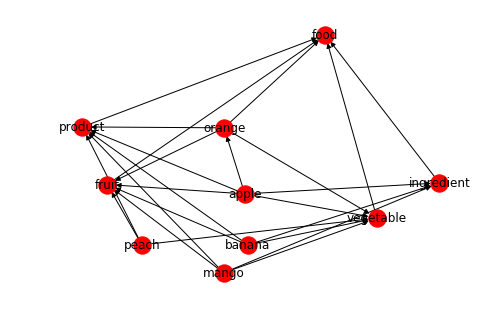

In [19]:
graph = aggregate_paths(select_paths(V, root, 3, G))
plot_graph(graph)

Overall, the following observations can be made:

Noisy relations result in significantly noisy hypernym graphs. Therefore, filtering out the relations (step 2.b) improves the accuracy. However, it also results lower recall. This is evident from the graphs constructed using paths of length = 2. 

Overall, the key challenge of taxonomy induction is to remove as much as noise as possible in each step (relations extraction, graph construction, graph pruning), while retaining as many accurate relations as possible. In this exercise, we introduced very simple techniques for filtering. However, the current state of the art involves many complicated graph optimization algorithms. The following papers provide further reading for interested readers:

a) <a href="http://www.cs.cmu.edu/~hovy/papers/10EMNLP-taxnomylearning.pdf">A Semi-Supervised Method to Learn and Construct Taxonomies using the Web</a>
<br>
b) <a href="https://www.aclweb.org/anthology/J/J13/J13-3007.pdf">OntoLearn Reloaded: A Graph-Based Algorithm for Taxonomy Induction</a><br>
c) <a href="https://infoscience.epfl.ch/record/227966/files/cikm_subseq.pdf">Taxonomy Induction Using Hypernym Subsequences</a>


## 📚 Exercise 2: Distributed Information Retrieval - SOLUTIONS

In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
import numpy as np


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/foroutan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 1. Preprocess the input text by tokenizing it and stemming it.

In [ ]:

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
with open("bread.txt") as f:
# with open("epfldocs.txt") as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]


#### 2. Vectorize the preprocessed text by producing the TF/IDF scores.

In [ ]:

# create the vocabulary
vocabulary = set([item for sublist in documents for item in sublist])
vocabulary = [word for word in vocabulary if word not in stopwords.words('english')]
vocabulary.sort()

# compute IDF, storing idf values in a dictionary
def idf_values(vocabulary, documents):
    """
    It computes IDF scores, storing idf values in a dictionary.
    
    :param vocabulary: list of str, with the unique tokens of the vocabulary.
    :param documents: list of lists of str, with tokenized sentences.
    :return: dict with the idf values for each vocabulary word.
    """
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf

# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    """
    It generates the vector for an input document (with normalization).
    
    :param document: list of str with the tokenized documents.
    :param vocabulary: list of str, with the unique tokens of the vocabulary.
    :param idf: dict with the idf values for each vocabulary word.
    :return: list of floats
    """
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term] * counts[term]/max_count
    return vector

# Function to compute cosine similarity
def cosine_similarity(v1,v2):
    """
    It computes cosine similarity.
    
    :param v1: list of floats, with the vector of a document.
    :param v2: list of floats, with the vector of a document.
    :return: float
    """
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def vectorize_query(query, vocabulary, idf):
    """
    It creates a vector for the given query.

    :param query: str
    :param vocabulary: list
    :param idf: dict
    """
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    return query_vector
    
def search_vec(query, k):
    """
    It computes the search result (get the topk documents).
    
    :param query: str
    :param topk: int
    """
    query_vector = vectorize_query(query, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    ans = []
    indices = []
    for i in range(min(k,len(original_documents))):
        ans.append(original_documents[scores[i][1]])
        indices.append(scores[i][1])
    return ans, indices, query_vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

#### 3. Create a dictionary $h$, where each entry of the dictionary corresponds to a posting list for a term, assumed to be hosted in a different node.

In [2]:
import numpy as np
import operator

doc_vecs = np.transpose(np.array(document_vectors))
h = {}
for i, term in enumerate(vocabulary):
    ha = {}
    for docj in range(len(original_documents)):
        tfidf = doc_vecs[i][docj]
        ha[docj] = tfidf
    sorted_ha = sorted(ha.items(), key=operator.itemgetter(1), reverse=True)
    h[term] = sorted_ha

#### 4. Complete the following function that implements the Fagin algorithm.

In [3]:
def fagin_algorithm(query, h, k, vocabulary):
    """
    It perofrms the Fahin algorithm.

    :param quer: str
    :param h: dict
    :param vocabulary: list
    """
    
    # Split and stem the query
    q = query.split()
    q = set([stemmer.stem(w) for w in q])
    query_term_cnt = len(q)
    
    # select the posting lists for the query terms
    posting_lists = {}
    for term in q:
        if term in h:
            posting_lists[term] = h[term]
    
    max_len = len(documents)
    
    # Traverse the selected posting lists until we found k documents that appear in ALL posting lists
    # This corresponds to phase 1 of Fagin's algorithm.
    # As a result you produce a dictionary documents_occurrences, with the document identifiers as keys, 
    # and the number of documents found as value.
    # We stop traversing the posting lists until we have found k documents that appear in ALL posting lists 
    # of the query terms

    documents_occurrences = {}
    l = 0
    found_documents = 0
    while l < max_len:
        for term in q:
            d  = posting_lists[term][l][0]
            if d in documents_occurrences.keys():
                documents_occurrences[d] = documents_occurrences[d]+1
            else:
                documents_occurrences[d] = 1
            if documents_occurrences[d] == query_term_cnt:
                found_documents = found_documents + 1
        if found_documents == k:
            l = max_len + 1
            break
        else:
            l = l+1
                
    print(documents_occurrences)
        
    # Retrieve for the found documents the tfidf values and add them up.
    # For simplicity, we do not distinguish the cases whether the values have already been retrieved in the 
    # previous phase, or whether we use random access to obtain those values
    
    tfidf = {}
    for d in documents_occurrences.keys():
        t = 0
        for term in q:
            t = t + dict(posting_lists[term])[d]
        tfidf[d] = t
        
    # Finally we compute the top-k documents and return the answer
    
    ans = sorted(tfidf.items(), key=lambda x:x[1], reverse = True)[:k]
    return ans


ans = fagin_algorithm("bread recipe", h, 2, vocabulary)
print(ans)
for document_id in ans:
    print(original_documents[document_id[0]])

{2: 1, 3: 2, 0: 2, 1: 1}
[(3, 1.1394342831883648), (0, 0.5697171415941824)]
Breads, Pastries, Pies, and Cakes: Quantity Baking Recipes
How to Bake Breads Without Baking Recipes


## 📚 Exercise 2: Inverted Files - SOLUTIONS 

In this exercise, we will understand the functioning of the Inverted Files and how implement them using MapReduce.

### Overview

We learnt in the lecture that terms are typically stored in an inverted list. Now, in the inverted list, instead of only storing document identifiers of the documents in which the term appears, assume we also store an *offset* of the appearance of a term in a document. An $offset$ of a term $l_k$ given a document is defined as the number of words between the start of the document and $l_k$. Thus our inverted list is now:

$l_k= \langle f_k: \{d_{i_1} \rightarrow [o_1,\ldots,o_{n_{i_1}}]\}, 
\{d_{i_2} \rightarrow [o_1,\ldots,o_{n_{i_2}}]\}, \ldots, 
\{d_{i_k} \rightarrow [o_1,\ldots,o_{n_{i_k}}]\} \rangle$

This means that in document $d_{i_1}$ term $l_k$ appears $n_{i_1}$ times and at offset $[o_1,\ldots,o_{n_{i_1}}]$, where $[o_1,\ldots,o_{n_{i_1}}]$ are sorted in ascending order, these type of indices are also known as term-offset indices. An example of a term-offset index is as follows:

**Obama** = $⟨4 : {1 → [3]},{2 → [6]},{3 → [2,17]},{4 → [1]}⟩$

**Governor** = $⟨2 : {4 → [3]}, {7 → [14]}⟩$

**Election** = $⟨4 : {1 → [1]},{2 → [1,21]},{3 → [3]},{5 → [16,22,51]}⟩$

Which is to say that the term **Governor** appear in 2 documents. In document 4 at offset 3, in document 7 at offset 14. Now let us consider the *SLOP/x* operator in text retrieval. This operator has the syntax: *QueryTerm1 SLOP/x QueryTerm2* finds occurrences of *QueryTerm1* within $x$ (but not necessarily in that order) words of *QueryTerm2*, where $x$ is a positive integer argument ($x \geq 1$). Thus $x = 1$ demands that *QueryTerm1* be adjacent to *QueryTerm2*.

### Questions

1. List the set of documents that satisfy the query **Obama** *SLOP/2* **Election**.
2. List each set of values for which the query **Obama** *SLOP/x* **Election** has a different set of documents as answers (starting from $x = 1$). 
3. Consider the general procedure for "merging" two term-offset inverted lists for a given document, to determine where the document satisfies a *SLOP/x* clause (since in general there will be many offsets at which each term occurs in a document). Let $L$ denote the total number of occurrences of the two terms in the document. Assume we have a pointer to the list of occurrences of each term and can move the pointer along this list. As we do so we check whether we have a hit for $SLOP/x$ (i.e. the $SLOP/x$ clause is satisfied). Each move of either pointer counts as a step. Based on this assumption is there a general "merging" procedure to determine whether the document satisfies a $SLOP/x$ clause, for which the following is true? Justify your answer.

    1. The merge can be accomplished in a number of steps linear in $L$ regardless of $x$, and we can ensure that each pointer moves only to the right (i.e. forward).
    2. The merge can be accomplished in a number of steps linear in $L$, but a pointer may be forced to move to the left (i.e. backwards).
    3. The merge can require $x \times L$ steps in some cases.
    
**Solution in pdf.**

## Create inverted files using MapReduce
In this exercise, we want to create the inverted files using the MapReduce framework. Write the **map** and **reduce** function.
Note that the code of **run_mapreduce** is just a simulation of the behavior of  map-reduce system.

## Goal:
- Create inverted files using the MapReduce framework.  
- Test the implementation on `epfldocs.txt` data.

### What you are learning in this exercise:
- Having a better understanding of inverted files.
- Learn how to implement inverted files using the MapReduce framework. 

In [6]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

# Tokenize, stem a document
def tokenize(text):
    """
    It tokenizes and stems an input text.
    
    :param text: str, with the input text
    :return: list, of the tokenized and stemmed tokens.
    """
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

with open("epfldocs.txt") as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]
docs_n_doc_ids = list(zip(range(len(documents)), documents))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/foroutan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/foroutan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Take a pair (doc_id, content). Example: (0, ['how', 'to', 'bake', 'bread', 'without', 'bake', 'recip'])
#Return: list of (word, doc_id). Example: ('bake', 0)
# For simplicity, we assume each mapper handles a document
def map_function(doc_id, content):
    keyvals = []
    for word in content:
        keyvals.append((word, doc_id))
    return keyvals

In [8]:
# Take a list of pairs (word, doc_id). Example:  [('bake', 0), ('bake', 0), ('bake', 3)]
# Return: (word, frequency, list of document ids). Example ('bake', 3, [0, 0, 3])
# For simplicity, we assume each reducer handles a word
def reduce_function(lst):
    total = 0
    word = lst[0][0]
    doc_ids = []
    for w, doc_id in lst:
        assert(word==w)
        total += 1
        doc_ids.append(doc_id)
    return (word,total, doc_ids)

In [9]:
# We simulate the mapreduce framework by this function
def run_mapreduce(docs_n_doc_ids):
    # Map phase
    key_values = []
    for doc_id, doc_content in docs_n_doc_ids:
        key_values.extend(map_function(doc_id, doc_content))
    # Shuffle phase
    values = set(map(lambda x:x[0], key_values))
    grouped_key_values = [[y for y in key_values if y[0]==x] for x in values]
    # Reduce phase
    inverted_files = []
    for grouped_key_value in grouped_key_values:
        word, total, doc_ids = reduce_function(grouped_key_value)
        inverted_files.append((word, total, doc_ids))
    return inverted_files

In [10]:
run_mapreduce(docs_n_doc_ids)

[('veri', 11, [125, 260, 293, 307, 333, 575, 629, 771, 808, 830, 963]),
 ('biolog', 10, [24, 30, 67, 73, 153, 298, 365, 625, 839, 932]),
 ('httpstcoesz9scdzao', 1, [416]),
 ('urbanism', 1, [261]),
 ('practic', 4, [318, 539, 937, 960]),
 ('vitro', 1, [354]),
 ('httpstco0l63qx5qmr', 1, [400]),
 ('visit', 11, [275, 427, 512, 512, 627, 700, 764, 810, 847, 895, 1037]),
 ('stewart', 1, [579]),
 ('april', 4, [30, 479, 642, 990]),
 ('vue', 1, [988]),
 ('inflight', 1, [318]),
 ('essenti', 1, [41]),
 ('arbor', 1, [913]),
 ('perriard', 1, [898]),
 ('httpstcozsy1cshedk', 1, [196]),
 ('jeanclaudebadoux', 1, [1022]),
 ('httpstcowmrbimab2g', 1, [664]),
 ('compon', 2, [256, 389]),
 ('hackdisrupt', 1, [218]),
 ('mesnier', 1, [63]),
 ('diplomtypu', 1, [188]),
 ('gdanezi', 1, [68]),
 ('youtubechanel', 1, [637]),
 ('no8', 1, [4]),
 ('excess', 1, [834]),
 ('reprendr', 1, [207]),
 ('hwurcc', 1, [575]),
 ('press', 2, [232, 589]),
 ('denken', 1, [338]),
 ('solarcel', 1, [986]),
 ('httpstcolijub1fwym', 1, [654

# Association Rules

Today, we will implement two techniques that are part of the so-called shopping basket analysis, which will help us to better understand how customers data are being processed to extract insights about their habits.


#### Notes about external libraries
You can check your implementation of the Apriori algorithm and the Association Rules using MLxtend, a data mining library. Unfortunately, the library is not directly shipped with Anaconda. To install MLxtend, just execute  

```bash
pip install mlxtend  
```

Or directly using Anaconda

```bash
conda install -c conda-forge mlxtend 
```

Note that the installation of MLxtend is not mandatory, as we will provide the expected results in pre-rendered cells.


## 📚 Exercise 1: Apriori algorithm
In the first excercise, we will put into practice the Apriori algorithm. In particular, we will extract frequent itemsets from a list of transactions coming from a grocery store. You will have to complete the function `get_support(...)`.

In [1]:
import operator
import numpy as np

"""
Format the transaction dataset.
Expect a list of transaction in the format:
[[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], ...]
"""
def preprocess(dataset):
    unique_items = set()
    for transaction in dataset:
        for item in transaction:
            unique_items.add(item)
       
    # Converting to frozensets to use itemsets as dict key
    unique_items = [frozenset([i]) for i in list(unique_items)]
    
    return unique_items,list(map(set,dataset))


"""
Generate candidates of length n+1 from a list of items, each of length n.

Example:
[{1}, {2}, {5}]          -> [{1, 2}, {1, 5}, {2, 5}]
[{2, 3}, {2, 5}, {3, 5}] -> [{2, 3, 5}]
"""
def generate_candidates(Lk):
    output = []

    # We generate rules of the target size k
    k=len(Lk[0])+1
    
    for i in range(len(Lk)):
        for j in range(i+1, len(Lk)): 
            L1 = list(Lk[i])[:k-2]; 
            L2 = list(Lk[j])[:k-2]
            L1.sort(); 
            L2.sort()

            # Merge sets if first k-2 elements are equal
            # For the case of k<2, generate all possible combinations
            if L1==L2: 
                output.append(Lk[i] | Lk[j])

    return output


"""
Print the results of the apriori algorithm
"""
def print_support(support,max_display=10,min_items=1):
    print('support\t itemset')
    print('-'*30)
    filt_support = {k:v for k,v in support.items() if len(k)>=min_items}
    for s,sup in sorted(filt_support.items(), key=operator.itemgetter(1),reverse=True)[:max_display]:
        print("%.2f" % sup,'\t',set(s))
        
def print_support_mx(df,max_display=10,min_items=1):
    print('support\t itemset')
    print('-'*30)
    lenrow = df['itemsets'].apply(lambda x: len(x))
    df  = df[lenrow>=min_items]
    df  = df.sort_values('support',ascending=False).iloc[:max_display]
    for i,row in df.iterrows():
        print("%.2f" % float(row['support']),'\t',set(row['itemsets']))
        


def apriori(dataset, min_support = 0.5):
    """
    Run the apriori algorithm

    dataset     : list of transactions
    min_support : minimum support. Itemsets with support below this threshold
                  will be pruned.
    """
    unique_items,dataset = preprocess(dataset)
    L1, supportData      = get_support(dataset, unique_items, min_support)
    
    L = [L1]
    k = 0
    while True:
        Ck       = generate_candidates(L[k])
        Lk, supK = get_support(dataset, Ck, min_support)
        
        # Is there itemsets of length k that have the minimum support ?
        if len(Lk)>0:
            supportData.update(supK)
            L.append(Lk) 
            k += 1
        else:
            break
            
    return L, supportData

#### TODO

Compute support for all the candidate itemsets contained in Ck, given the total list of transactions. We already provide the functions to compute candidate itemsets. The support of the itemset $X$ with respect to the list of transactions $T$ is defined as the proportion of transactions $t$ in the dataset which contains the itemset $X$. Support can be computed using the following formula

$$\mathrm{supp}(X) = \frac{|\{t \in T; X \subseteq t\}|}{|T|}$$  

After computing the support for each itemset, prune the ones that do not match the minimal specificied support.

In [2]:
"""
Compute support for each provided itemset by counting the number of
its occurences in the original dataset of transactions.

dataset      : list of transactions, preprocessed using 'preprocess()'
Ck           : list of itemsets to compute support for. 
min_support  : minimum support. Itemsets with support below this threshold
               will be pruned.
              
output       : list of remaining itemsets, after the pruning step.
support_dict : dictionary containing the support value for each itemset.
"""
def get_support(dataset, Ck, min_support):
    support_count = {}
    for transaction in dataset:
        for candidate in Ck:
            if candidate.issubset(transaction):
                if not candidate in support_count: support_count[candidate]=1
                else: support_count[candidate] += 1
                    
    num_transactions = float(len(dataset))
    output = []
    support_dict = {}
    for key in support_count:
        support = support_count[key]/num_transactions
        if support >= min_support:
            output.insert(0,key)
            support_dict[key] = support
    return output, support_dict

In [3]:
dataset = [ l.strip().split(',') for i,l in enumerate(open('groceries.csv').readlines())]

L,support = apriori(dataset,min_support=0.01)
print_support(support,10,min_items=2)

support	 itemset
------------------------------
0.07 	 {'other vegetables', 'whole milk'}
0.06 	 {'rolls/buns', 'whole milk'}
0.06 	 {'yogurt', 'whole milk'}
0.05 	 {'root vegetables', 'whole milk'}
0.05 	 {'root vegetables', 'other vegetables'}
0.04 	 {'yogurt', 'other vegetables'}
0.04 	 {'other vegetables', 'rolls/buns'}
0.04 	 {'tropical fruit', 'whole milk'}
0.04 	 {'soda', 'whole milk'}
0.04 	 {'soda', 'rolls/buns'}


## Checking

In [4]:
import pandas as pd
from mlxtend.frequent_patterns import apriori as mx_apriori

df_dummy = pd.get_dummies(pd.Series(dataset).apply(pd.Series).stack()).sum(level=0)
frequent_itemsets = mx_apriori(df_dummy, min_support=0.01, use_colnames=True)
print_support_mx(frequent_itemsets,10,min_items=2)

support	 itemset
------------------------------
0.07 	 {'other vegetables', 'whole milk'}
0.06 	 {'rolls/buns', 'whole milk'}
0.06 	 {'yogurt', 'whole milk'}
0.05 	 {'root vegetables', 'whole milk'}
0.05 	 {'root vegetables', 'other vegetables'}
0.04 	 {'yogurt', 'other vegetables'}
0.04 	 {'other vegetables', 'rolls/buns'}
0.04 	 {'tropical fruit', 'whole milk'}
0.04 	 {'soda', 'whole milk'}
0.04 	 {'soda', 'rolls/buns'}


## 📚 Exercise 2: Association Rule Learning
Such associations are not necessarily symmetric. Therefore, in the second part, we will use [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) to better understand the directionality of our computed frequent itemsets. In other terms, we will have to infer if the purchase of one item generally implies the the purchase of another.

In [6]:
"""
L              : itemsets
supportData    : dictionary storing itemsets support
min_confidence : rules with a confidence under this threshold should be pruned
"""
def generate_rules(L, supportData, min_confidence=0.7):  
    # Rules to be computed
    rules = []
    
    # Iterate over itemsets of length 2..N
    for i in range(1, len(L)):
        
        # Iterate over each frequent itemset
        for freqSet in L[i]:
            H1 = [frozenset([item]) for item in freqSet]
            
            # If the itemset contains more than 2 elements
            # recursively generate candidates 
            if (i+1 > 2):
                rules_from_consequent(freqSet, H1, supportData, rules, min_confidence)
                compute_confidence(freqSet, H1, supportData, rules, min_confidence)
            # If the itemsset contains 2 or less elements
            # conpute rule confidence
            else:
                compute_confidence(freqSet, H1, supportData, rules, min_confidence)

    return rules   

"""
freqSet        : frequent itemset
H              : candidate elements to create a rule
supportData    : dictionary storing itemsets support
rules          : array to store rules
min_confidence : rules with a confidence under this threshold should be pruned
"""
def rules_from_consequent(freqSet, H, supportData, rules, min_confidence=0.7):
    m = len(H[0])
    if (len(freqSet) > (m + 1)): 

        # create new candidates of size n+1
        Hmp1 = generate_candidates(H)
        Hmp1 = compute_confidence(freqSet, Hmp1, supportData, rules, min_confidence)
        
        if (len(Hmp1) > 1):    #need at least two sets to merge
            rules_from_consequent(freqSet, Hmp1, supportData, rules, min_confidence)
            
"""
Print the resulting rules
"""
def print_rules(rules,max_display=10):
    print('confidence\t rule')
    print('-'*30)
    for a,b,sup in sorted(rules, key=lambda x: x[2],reverse=True)[:max_display]:
        print("%.2f" % sup,'\t',set(a),'->',set(b))
def print_rules_mx(df,max_display=10):
    print('confidence\t rule')
    print('-'*30)
    df  = df.sort_values('confidence',ascending=False).iloc[:max_display]
    for i,row in df.iterrows():
        print("%.2f" % float(row['confidence']),'\t',set(row['antecedents']),'->',set(row['consequents']))

#### TODO:

You will have to complete the method `compute_confidence(...)`, that computes confidence for a set of candidate rules H and prunes the rules that have a confidence below the specified threshold. Please complete it by computing rules confidence using the following formula:

$$\mathrm{conf}(X \Rightarrow Y) = \mathrm{supp}(X \cup Y) / \mathrm{supp}(X)$$


In [5]:
"""
Compute confidence for a given set of rules and their respective support

freqSet        : frequent itemset of N-element
H              : list of candidate elements Y1, Y2... that are part of the frequent itemset
supportData    : dictionary storing itemsets support
rules          : array to store rules
min_confidence : rules with a confidence under this threshold should be pruned
"""
def compute_confidence(freqSet, H, supportData, rules, min_confidence=0.7):
    prunedH = [] 
    
    for Y in H:
        X           = freqSet - Y
        support_XuY = supportData[freqSet]
        support_X   = supportData[X]
        
        conf        = support_XuY/support_X
        
        if conf >= min_confidence: 
            rules.append((X, Y, conf))
            prunedH.append(Y)
    return prunedH

In [7]:
rules=generate_rules(L,support, min_confidence=0.1)
print_rules(rules,10)

confidence	 rule
------------------------------
0.59 	 {'citrus fruit', 'root vegetables'} -> {'other vegetables'}
0.58 	 {'root vegetables', 'tropical fruit'} -> {'other vegetables'}
0.58 	 {'curd', 'yogurt'} -> {'whole milk'}
0.57 	 {'butter', 'other vegetables'} -> {'whole milk'}
0.57 	 {'root vegetables', 'tropical fruit'} -> {'whole milk'}
0.56 	 {'root vegetables', 'yogurt'} -> {'whole milk'}
0.55 	 {'other vegetables', 'domestic eggs'} -> {'whole milk'}
0.52 	 {'yogurt', 'whipped/sour cream'} -> {'whole milk'}
0.52 	 {'root vegetables', 'rolls/buns'} -> {'whole milk'}
0.52 	 {'pip fruit', 'other vegetables'} -> {'whole milk'}


## Checking

In [8]:
from mlxtend.frequent_patterns import association_rules as mx_association_rules

rules_mx = mx_association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print_rules_mx(rules_mx,max_display=10)

confidence	 rule
------------------------------
0.59 	 {'citrus fruit', 'root vegetables'} -> {'other vegetables'}
0.58 	 {'root vegetables', 'tropical fruit'} -> {'other vegetables'}
0.58 	 {'curd', 'yogurt'} -> {'whole milk'}
0.57 	 {'butter', 'other vegetables'} -> {'whole milk'}
0.57 	 {'root vegetables', 'tropical fruit'} -> {'whole milk'}
0.56 	 {'root vegetables', 'yogurt'} -> {'whole milk'}
0.55 	 {'other vegetables', 'domestic eggs'} -> {'whole milk'}
0.52 	 {'yogurt', 'whipped/sour cream'} -> {'whole milk'}
0.52 	 {'root vegetables', 'rolls/buns'} -> {'whole milk'}
0.52 	 {'pip fruit', 'other vegetables'} -> {'whole milk'}


## EPFL Twitter Data

Now that we have a working implementation, we will apply the Apriori algorithm on a dataset that you should know pretty well by now: EPFL Twitter data. In that scenario, tweets will be considered as transactions and words will be items. Let's see what kind of frequent associations we can discover.

The method below cleans the tweets and formats them in the same format as the transactions of the previous exercise. Run the cells and generate the results for both algorithms. What can you observe from the association rules results? Briefly explain.

In [9]:
# Loading of libraries and documents

from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize, stem a document
stemmer = PorterStemmer()
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Remove stop words
def clean_voc(documents):
    cleaned = []
    for tweet in documents:
        new_tweet = []
        tweet = tokenize(tweet).split()
        for word in tweet:
            if (word not in stopwords.words('english') and 
                word not in stopwords.words('german') and
                word not in stopwords.words('french')):
                if word=="epflen":
                    word = "epfl"
                new_tweet.append(word)
        if len(new_tweet)>0:
            cleaned.append(new_tweet)
    return cleaned

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt") as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = clean_voc(original_documents)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/freened/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/freened/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
L,support = apriori(documents,min_support = 0.01)
print_support(support,20,min_items=2)

support	 itemset
------------------------------
0.08 	 {'via', 'epfl'}
0.05 	 {'new', 'epfl'}
0.05 	 {'amp', 'epfl'}
0.05 	 {'research', 'epfl'}
0.04 	 {'lausann', 'epfl'}
0.04 	 {'vdtech', 'epfl'}
0.04 	 {'switzerland', 'epfl'}
0.04 	 {'robot', 'epfl'}
0.03 	 {'day', 'epfl'}
0.03 	 {'swiss', 'epfl'}
0.03 	 {'via', 'vdtech'}
0.03 	 {'via', 'vdtech', 'epfl'}
0.03 	 {'epfl', 'scienc'}
0.03 	 {'innov', 'epfl'}
0.03 	 {'student', 'epfl'}
0.03 	 {'first', 'epfl'}
0.03 	 {'work', 'epfl'}
0.02 	 {'2018', 'epfl'}
0.02 	 {'technolog', 'epfl'}
0.02 	 {'learn', 'epfl'}


In [11]:
rules=generate_rules(L,support, min_confidence=0.1)
print_rules(rules,20)

confidence	 rule
------------------------------
1.00 	 {'model'} -> {'epfl'}
1.00 	 {'perovskit'} -> {'epfl'}
1.00 	 {'next'} -> {'epfl'}
1.00 	 {'improv'} -> {'epfl'}
1.00 	 {'particip'} -> {'epfl'}
1.00 	 {'epflcampu'} -> {'epfl'}
1.00 	 {'learn'} -> {'epfl'}
1.00 	 {'present'} -> {'epfl'}
1.00 	 {'mooc'} -> {'epfl'}
1.00 	 {'show'} -> {'epfl'}
1.00 	 {'brain'} -> {'epfl'}
1.00 	 {'scientist'} -> {'epfl'}
1.00 	 {'eth'} -> {'epfl'}
1.00 	 {'via', 'vdtech'} -> {'epfl'}
0.98 	 {'vdtech'} -> {'epfl'}
0.97 	 {'robot'} -> {'epfl'}
0.97 	 {'swiss'} -> {'epfl'}
0.97 	 {'student'} -> {'epfl'}
0.96 	 {'first'} -> {'epfl'}
0.96 	 {'technolog'} -> {'epfl'}


## 📚 Exercise 3: Pen and Paper!

You are given the following accident and weather data. Each line corresponds to one event:

1. car_accident rain lightning wind clouds fire
2. fire clouds rain lightning wind
3. car_accident fire wind
4. clouds rain wind
5. lightning fire rain clouds 6. clouds wind car_accident 7. rain lightning clouds fire 8. lightning fire car_accident

(a) You would like to know what is the likely cause of all the car accidents. What association rules do you need to look for? Compute the confidence and support values for these rules. Looking at these values, which is the most likely cause of the car accidents?

(b) Find all the association rules for minimal support 0.6 and minimal confidence of 1.0 (certainty). Follow the apriori algorithm.

## Solution
We need to look for the association rules of the form: {cause} → {car accident}
i.e. in which the left-hand side represents the cause of the accident. 

The possible association rules are: 
{lightning} → {car accident} support: 0.25 confidence: 0.4
{wind} → {car accident} support: 0.375 confidence: 0.6
{fire} → {car accident} support: 0.375 confidence: 0.5
{clouds} → {car accident} support: 0.25 confidence: 0.33
{rain} → {car accident} support: 0.125 confidence: 0.2

{wind}has both the highest confidence and the highest support and is the most likely cause of the car accidents.


We first find all the frequent itemsets of size one. The minimal support requirement is 0.6,
which means that to be frequent an itemset must occur in at least 5 out of the 8 transactions, 5/8 = 0.
6.25≥0.6. There are five frequent itemsets:{clouds} support: 0.75
{wind} support: 0.625
{lightning} support: 0.625
{rain} support: 0.625
{fire} support: 0.75
From the above itemsets we next generate all possible itemsets of size 2 and prune the itemsets with support below 0.6. Only two itemsets remain:
{lightning, fire} support: 0.625
{clouds, rain} support: 0.625
It is not possible to generate the itemsets of size 3 out of the above 2 itemsets, the intersection is empty. Based on the itemsets of size 2 we generate all possible association rules and compute their confidence:
 {lightning} →{fire} support: 0.625 confidence: 1.0
{fire} → {lightning} support: 0.625 confidence: 0.833
{clouds} → {rain} support: 0.625 confidence: 0.833
{rain} → {clouds} support: 0.625 confidence: 1.0
There are only two association rules with confidence equal to 1 and that is the final solution.
